In [32]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, NullFormatter, FuncFormatter
import numpy as np
import os.path
from os import path
import math
plt.rcParams['figure.figsize'] = [15, 5]
plt.set_cmap(matplotlib.colormaps['Set2'])
np.random.seed(2021)
file_location = "../results/"
img_output = "./graphs/"

<Figure size 1080x360 with 0 Axes>

In [2]:
types = ["normal", "natural", "sparse", "triangle", ]
algorithms_gcc = ["eigen", "openmp-cpu", "openmp-offload"]
algorithms_nvcc = ["openacc", "cuda", "cublas", "openmp-offload"]
sizes = np.array([2**x for x in range(1,15)]) #2^15 = 16384
compilers = ["gcc-offload", "clang-offload", "nvcc-offload", "gcc-offload-acc", "gcc-offload-dbl", "clang-offload-dbl", "nvcc-offload-dbl", "gcc-offload-acc-dbl"]

In [3]:
split = 1000
choices_arr = [list(range(x**2)) for x in sizes[:10]]
choices_arr.extend([np.sort(np.random.choice(x**2, split**2, False)) for x in sizes[10:]])

In [4]:
def process_timings(compiler, method, matrix_type, dbl = False):
    avg_across = []
    for size in sizes:
        #print("comp: " + compiler + " algo: " + method + " type: " + matrix_type + " dbl: " + str(dbl) + " size: " + str(size)) 
        avgs = []
        if dbl:
            fstring = file_location + compiler + "-dbl_" + method + "_" + matrix_type + "_" + str(size) + "_double"
        else:
            fstring = file_location + compiler + "_" + method + "_" + matrix_type + "_" + str(size)
        if not path.exists(fstring):
            print("path does not exist: ", fstring)
            continue
        file = open(fstring)
        
        line = file.readline()
        while line and line[0] != "-" and line[0] != "C":
            avgs.append(float(line))
            line = file.readline()
        if avgs:
            avg_across.append(np.mean(np.array(avgs)))
    return np.array(avg_across)


def process_error(compiler, method, matrix_type, size, dbl = False):
    if dbl:
        fstring = file_location + compiler + "-dbl_" + method + "_" + matrix_type + "_" + str(size) + "_double"
    else:
        fstring = file_location + compiler + "_" + method + "_" + matrix_type + "_" + str(size)
    if not path.exists(fstring):
        print("path does not exist: ", fstring)
        return []
    file = open(fstring)
        
    choices = choices_arr[int(math.log(int(size), 2)) - 1]
    choices = list(choices)
    
    errors = []
    
    line = file.readline()
    if not line:
        print("file is empty: ", fstring)
        return []
    while line and line[:1] != "-":
        line = file.readline()
    
    line = file.readline()
    l = 0
    for c in choices:#l in range(size**2):
        while l != c:
            line = file.readline()
            if not line or line[0] == "N":
                print(l, c, line)
                break
            l += 1
        if not line or line[0] == "N":
            print("NaN or abrupts ending: ", fstring)
            break
        errors.append(float(line))
    
    if not errors:
        return []
    errors.sort()
    return errors

def process_errors(compiler, method, matrix_type, dbl = False, maxsize = sizes[-1]):
    err_across = []
    for size in sizes[:int(math.log(int(size), 2)) - 1]:
        err = process_error(compiler, method, matrix_type, size, dbl)
        if len(err):
            err_across.append(err)
    return err_across

def compare_errors():
    return 0

def log_formatter(x, pos):
    return str(x)

In [24]:
def plot_timings(data, title):
    fig = plt.figure()
    ax = fig.subplots()
    ax.set_yscale("log")
    ax.set_xscale("log")
    avg = []
    for inp in data:
        ax.plot(np.array(sizes[:len(inp[0])]), inp[0], label=inp[1])

    ax.xaxis.set_major_formatter(ScalarFormatter())
    ax.xaxis.set_minor_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(FuncFormatter(log_formatter))
    ax.yaxis.set_minor_formatter(NullFormatter())
    
    ax.set_xticks(sizes)
    ax.legend()
    ax.grid()
    plt.show()
    fig.savefig(img_output + "timings_" + title + ".png")
    
def plot_speedup(base, data, title):
    fig = plt.figure()
    ax = fig.subplots()
    ax.grid(axis='y')
    ax.set_yscale("log")
    ax.yaxis.set_major_formatter(FuncFormatter(log_formatter))
    w = 1 / (len(data) + 2)
    ax.bar(np.arange(len(base[0])), np.ones(len(base[0])), width = w, label=base[1])
    
    for counter, inp in enumerate(data):
        plt.bar(np.arange(min(len(inp[0]), len(base[0]))) + (1 + counter) * w, base[0][:len(inp[0])] / inp[0][:len(base[0])], width = w, label=inp[1])

    ax.set_xticks([r + w for r in range(len(base[0]))], [str(x) for x in sizes[:len(base[0])]])
    ax.legend()
    ax.set_title(title)
    plt.show()
    fig.savefig(img_output + "speedup_" + title + ".png")
    
def plot_errors(errs, title):
    fig = plt.figure()
    ax = fig.subplots()
    ax.boxplot(errs)
    ax.xaxis.set_major_formatter(ScalarFormatter())
    ax.xaxis.set_minor_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(FuncFormatter(log_formatter))
    ax.yaxis.set_minor_formatter(NullFormatter())
    ax.grid()
    ax.set_title(title)
    ax.set_xticks(range(1, len(errs) + 1), [str(x) for x in sizes[:len(errs)]])
    plt.show()
    fig.savefig(img_output + "errors_" + title + ".png")

path does not exist:  ../results/gcc-offload_openmp-cpu_normal_2048
path does not exist:  ../results/gcc-offload_openmp-cpu_normal_4096
path does not exist:  ../results/gcc-offload_openmp-cpu_normal_8192
path does not exist:  ../results/gcc-offload_openmp-cpu_normal_16384
path does not exist:  ../results/gcc-offload_openmp-offload_normal_2048
path does not exist:  ../results/gcc-offload_openmp-offload_normal_4096
path does not exist:  ../results/gcc-offload_openmp-offload_normal_8192
path does not exist:  ../results/gcc-offload_openmp-offload_normal_16384


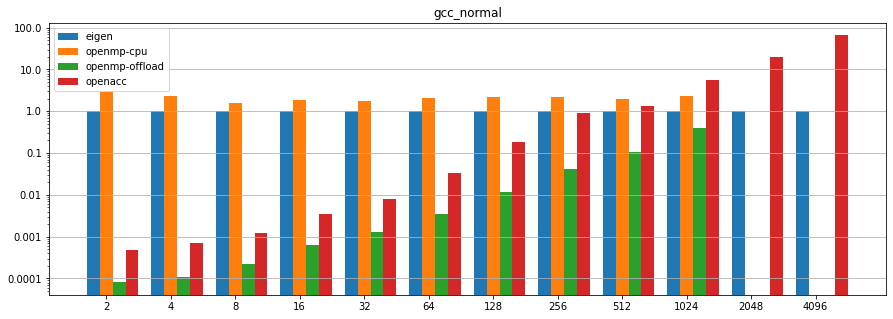

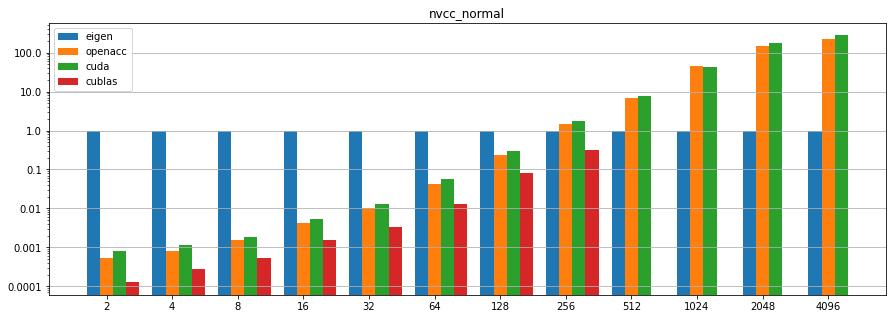

path does not exist:  ../results/clang-offload_openmp-offload_normal_2048
path does not exist:  ../results/clang-offload_openmp-offload_normal_4096
path does not exist:  ../results/clang-offload_openmp-offload_normal_8192
path does not exist:  ../results/clang-offload_openmp-offload_normal_16384


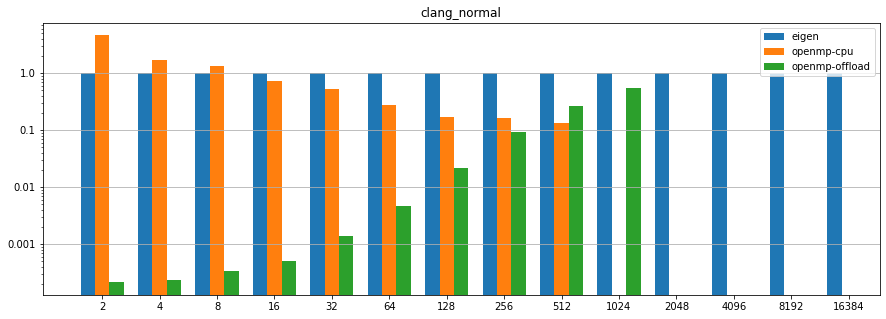

path does not exist:  ../results/gcc-offload_eigen_natural_8192
path does not exist:  ../results/gcc-offload_eigen_natural_16384
path does not exist:  ../results/gcc-offload_openmp-cpu_natural_2048
path does not exist:  ../results/gcc-offload_openmp-cpu_natural_4096
path does not exist:  ../results/gcc-offload_openmp-cpu_natural_8192
path does not exist:  ../results/gcc-offload_openmp-cpu_natural_16384
path does not exist:  ../results/gcc-offload_openmp-offload_natural_2048
path does not exist:  ../results/gcc-offload_openmp-offload_natural_4096
path does not exist:  ../results/gcc-offload_openmp-offload_natural_8192
path does not exist:  ../results/gcc-offload_openmp-offload_natural_16384


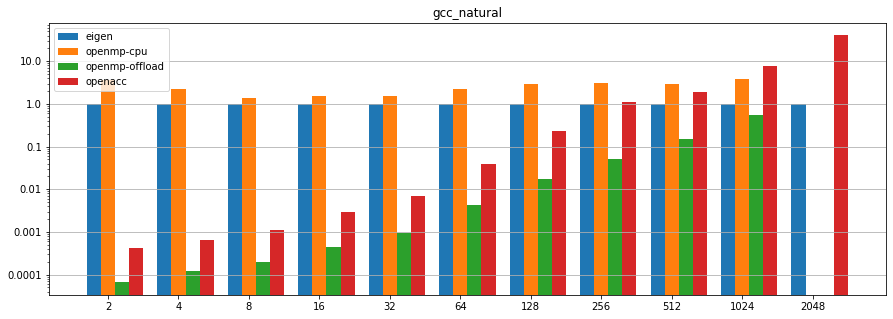

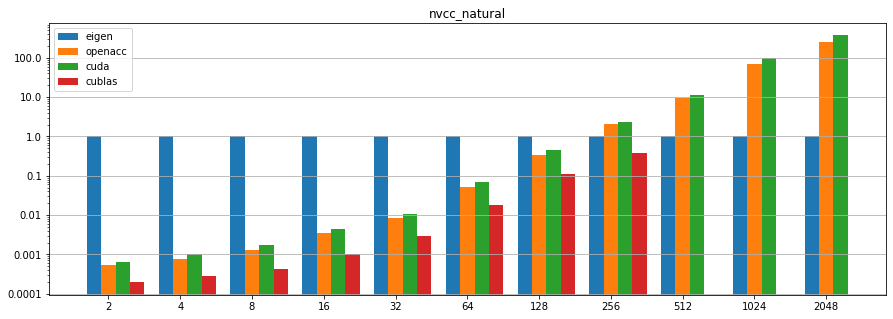

path does not exist:  ../results/clang-offload_openmp-offload_natural_2048
path does not exist:  ../results/clang-offload_openmp-offload_natural_4096
path does not exist:  ../results/clang-offload_openmp-offload_natural_8192
path does not exist:  ../results/clang-offload_openmp-offload_natural_16384


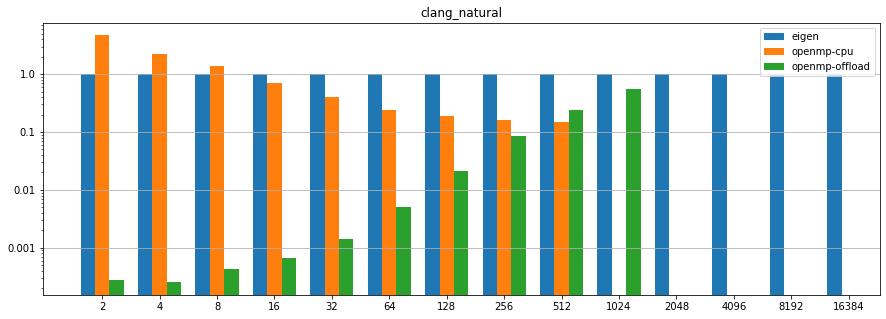

path does not exist:  ../results/gcc-offload_eigen_sparse_2048
path does not exist:  ../results/gcc-offload_eigen_sparse_4096
path does not exist:  ../results/gcc-offload_eigen_sparse_8192
path does not exist:  ../results/gcc-offload_eigen_sparse_16384
path does not exist:  ../results/gcc-offload_openmp-cpu_sparse_2048
path does not exist:  ../results/gcc-offload_openmp-cpu_sparse_4096
path does not exist:  ../results/gcc-offload_openmp-cpu_sparse_8192
path does not exist:  ../results/gcc-offload_openmp-cpu_sparse_16384
path does not exist:  ../results/gcc-offload_openmp-offload_sparse_2048
path does not exist:  ../results/gcc-offload_openmp-offload_sparse_4096
path does not exist:  ../results/gcc-offload_openmp-offload_sparse_8192
path does not exist:  ../results/gcc-offload_openmp-offload_sparse_16384


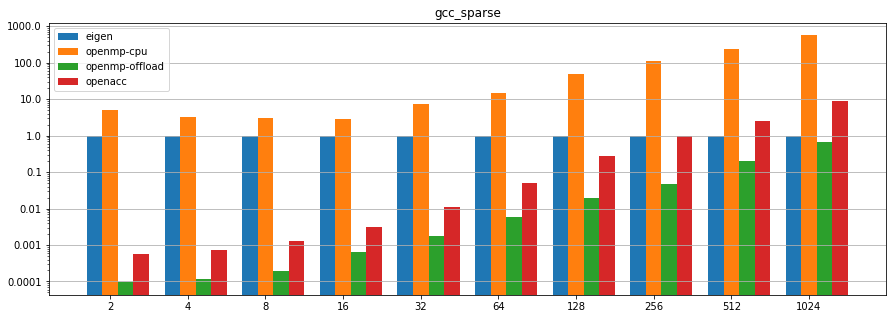

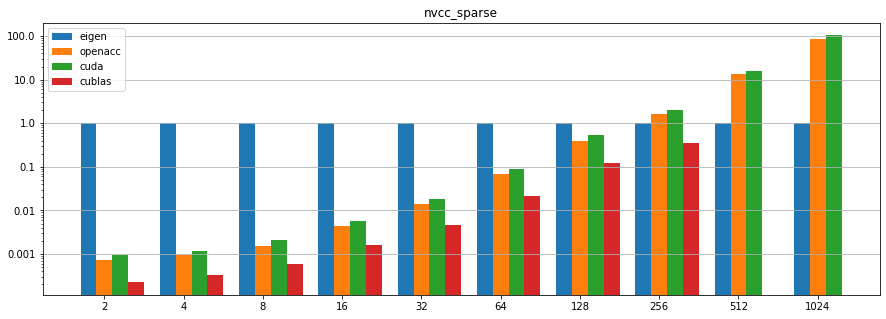

path does not exist:  ../results/clang-offload_openmp-cpu_sparse_2048
path does not exist:  ../results/clang-offload_openmp-cpu_sparse_4096
path does not exist:  ../results/clang-offload_openmp-cpu_sparse_8192
path does not exist:  ../results/clang-offload_openmp-cpu_sparse_16384
path does not exist:  ../results/clang-offload_openmp-offload_sparse_2048
path does not exist:  ../results/clang-offload_openmp-offload_sparse_4096
path does not exist:  ../results/clang-offload_openmp-offload_sparse_8192
path does not exist:  ../results/clang-offload_openmp-offload_sparse_16384


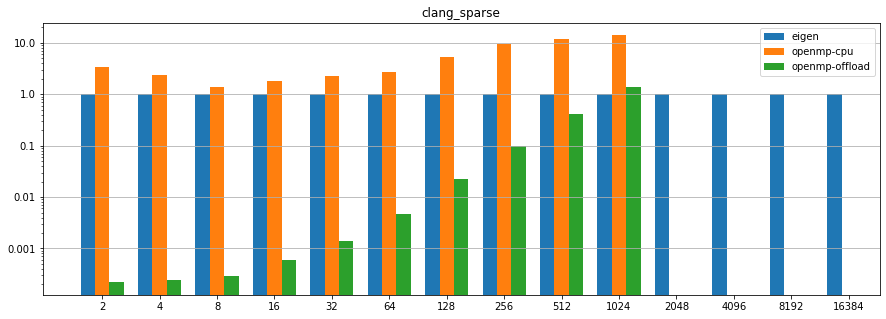

path does not exist:  ../results/gcc-offload_eigen_triangle_2048
path does not exist:  ../results/gcc-offload_eigen_triangle_4096
path does not exist:  ../results/gcc-offload_eigen_triangle_8192
path does not exist:  ../results/gcc-offload_eigen_triangle_16384
path does not exist:  ../results/gcc-offload_openmp-cpu_triangle_2048
path does not exist:  ../results/gcc-offload_openmp-cpu_triangle_4096
path does not exist:  ../results/gcc-offload_openmp-cpu_triangle_8192
path does not exist:  ../results/gcc-offload_openmp-cpu_triangle_16384
path does not exist:  ../results/gcc-offload_openmp-offload_triangle_2048
path does not exist:  ../results/gcc-offload_openmp-offload_triangle_4096
path does not exist:  ../results/gcc-offload_openmp-offload_triangle_8192
path does not exist:  ../results/gcc-offload_openmp-offload_triangle_16384


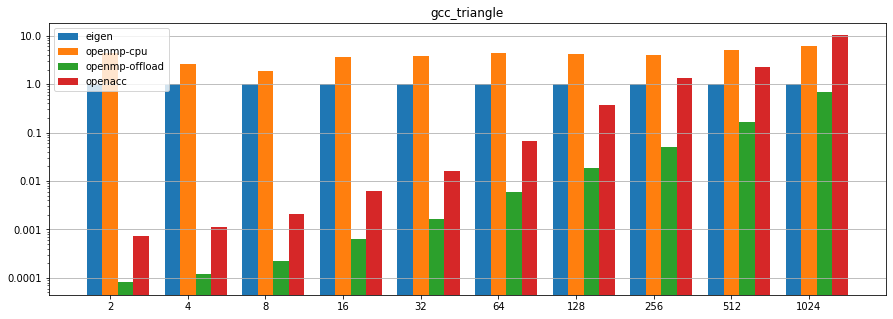

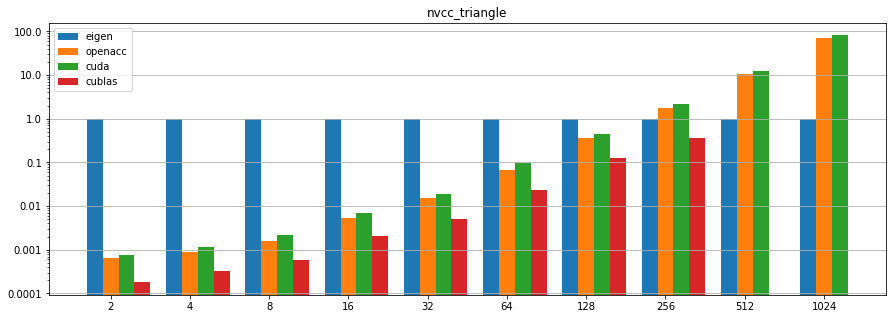

path does not exist:  ../results/clang-offload_openmp-cpu_triangle_2048
path does not exist:  ../results/clang-offload_openmp-cpu_triangle_4096
path does not exist:  ../results/clang-offload_openmp-cpu_triangle_8192
path does not exist:  ../results/clang-offload_openmp-cpu_triangle_16384
path does not exist:  ../results/clang-offload_openmp-offload_triangle_2048
path does not exist:  ../results/clang-offload_openmp-offload_triangle_4096
path does not exist:  ../results/clang-offload_openmp-offload_triangle_8192
path does not exist:  ../results/clang-offload_openmp-offload_triangle_16384


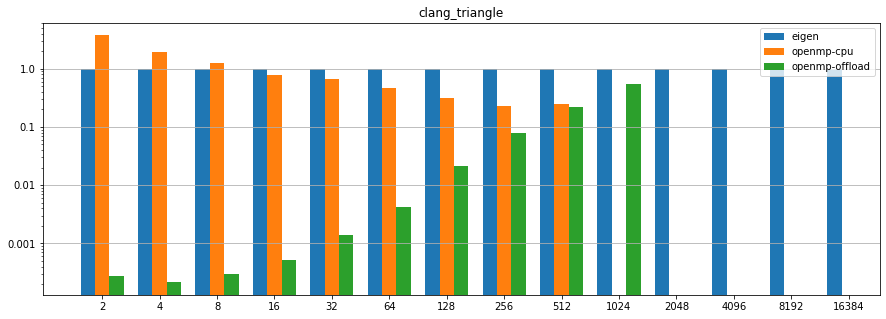

path does not exist:  ../results/gcc-offload-dbl_openmp-cpu_normal_2048_double
path does not exist:  ../results/gcc-offload-dbl_openmp-cpu_normal_4096_double
path does not exist:  ../results/gcc-offload-dbl_openmp-cpu_normal_8192_double
path does not exist:  ../results/gcc-offload-dbl_openmp-cpu_normal_16384_double
path does not exist:  ../results/gcc-offload-dbl_openmp-offload_normal_2048_double
path does not exist:  ../results/gcc-offload-dbl_openmp-offload_normal_4096_double
path does not exist:  ../results/gcc-offload-dbl_openmp-offload_normal_8192_double
path does not exist:  ../results/gcc-offload-dbl_openmp-offload_normal_16384_double


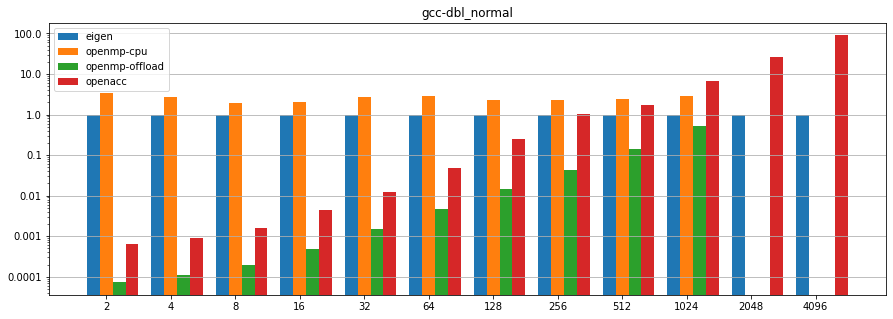

path does not exist:  ../results/nvcc-offload-dbl_cublas_normal_2048_double
path does not exist:  ../results/nvcc-offload-dbl_cublas_normal_4096_double
path does not exist:  ../results/nvcc-offload-dbl_cublas_normal_8192_double
path does not exist:  ../results/nvcc-offload-dbl_cublas_normal_16384_double


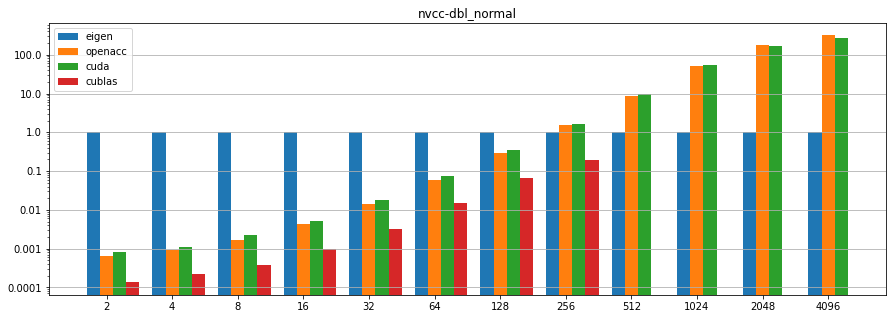

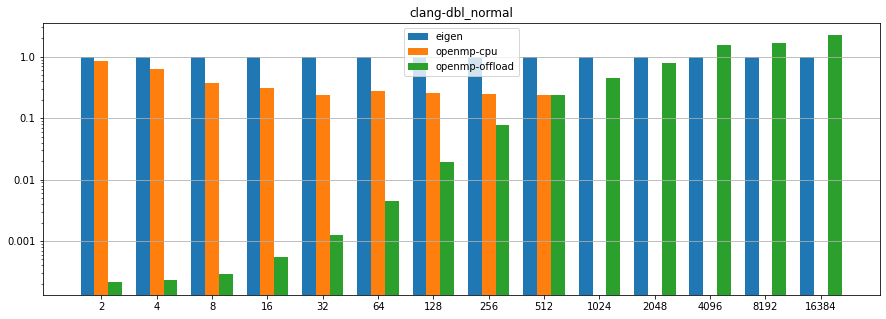

path does not exist:  ../results/gcc-offload-dbl_openmp-cpu_natural_2048_double
path does not exist:  ../results/gcc-offload-dbl_openmp-cpu_natural_4096_double
path does not exist:  ../results/gcc-offload-dbl_openmp-cpu_natural_8192_double
path does not exist:  ../results/gcc-offload-dbl_openmp-cpu_natural_16384_double
path does not exist:  ../results/gcc-offload-dbl_openmp-offload_natural_2048_double
path does not exist:  ../results/gcc-offload-dbl_openmp-offload_natural_4096_double
path does not exist:  ../results/gcc-offload-dbl_openmp-offload_natural_8192_double
path does not exist:  ../results/gcc-offload-dbl_openmp-offload_natural_16384_double


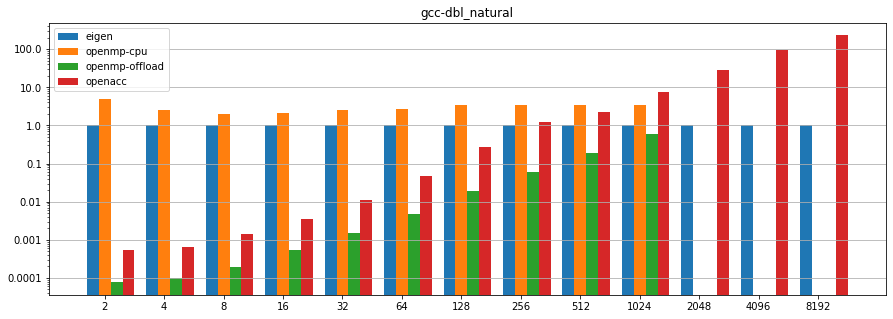

path does not exist:  ../results/nvcc-offload-dbl_cublas_natural_2048_double
path does not exist:  ../results/nvcc-offload-dbl_cublas_natural_4096_double
path does not exist:  ../results/nvcc-offload-dbl_cublas_natural_8192_double
path does not exist:  ../results/nvcc-offload-dbl_cublas_natural_16384_double


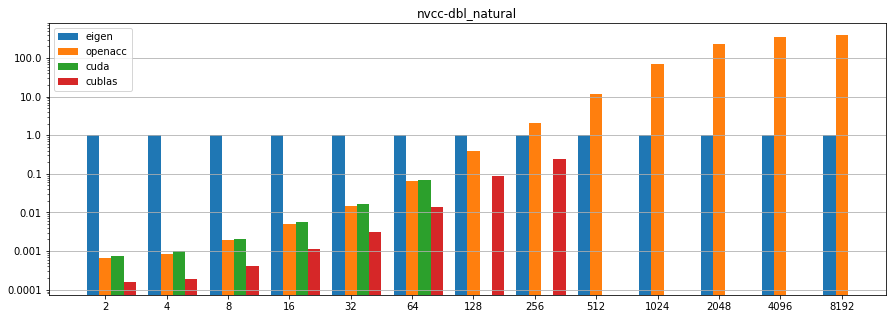

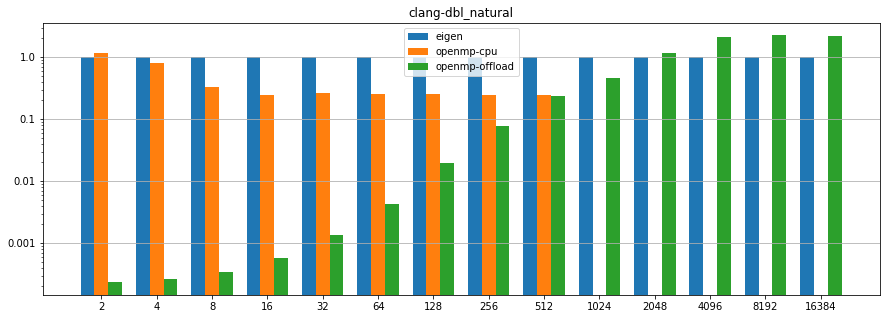

path does not exist:  ../results/gcc-offload-dbl_eigen_sparse_2048_double
path does not exist:  ../results/gcc-offload-dbl_eigen_sparse_4096_double
path does not exist:  ../results/gcc-offload-dbl_eigen_sparse_8192_double
path does not exist:  ../results/gcc-offload-dbl_eigen_sparse_16384_double
path does not exist:  ../results/gcc-offload-dbl_openmp-cpu_sparse_2048_double
path does not exist:  ../results/gcc-offload-dbl_openmp-cpu_sparse_4096_double
path does not exist:  ../results/gcc-offload-dbl_openmp-cpu_sparse_8192_double
path does not exist:  ../results/gcc-offload-dbl_openmp-cpu_sparse_16384_double
path does not exist:  ../results/gcc-offload-dbl_openmp-offload_sparse_2048_double
path does not exist:  ../results/gcc-offload-dbl_openmp-offload_sparse_4096_double
path does not exist:  ../results/gcc-offload-dbl_openmp-offload_sparse_8192_double
path does not exist:  ../results/gcc-offload-dbl_openmp-offload_sparse_16384_double


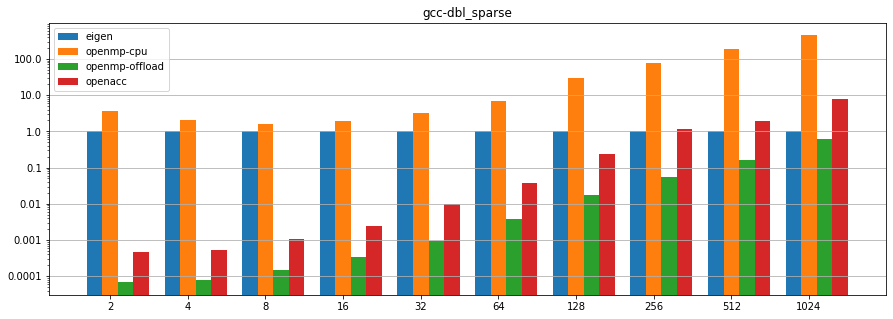

path does not exist:  ../results/nvcc-offload-dbl_cublas_sparse_2048_double
path does not exist:  ../results/nvcc-offload-dbl_cublas_sparse_4096_double
path does not exist:  ../results/nvcc-offload-dbl_cublas_sparse_8192_double
path does not exist:  ../results/nvcc-offload-dbl_cublas_sparse_16384_double


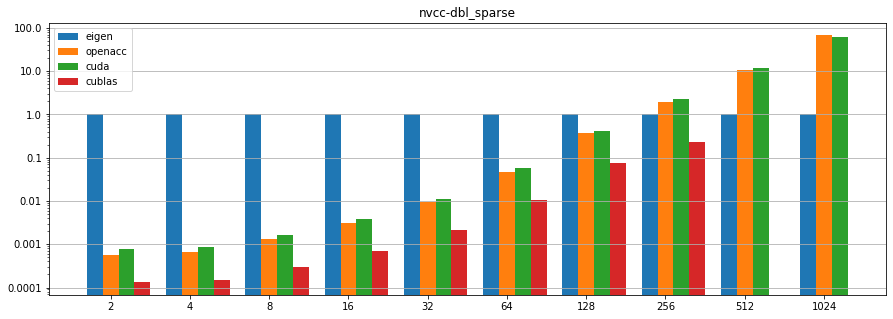

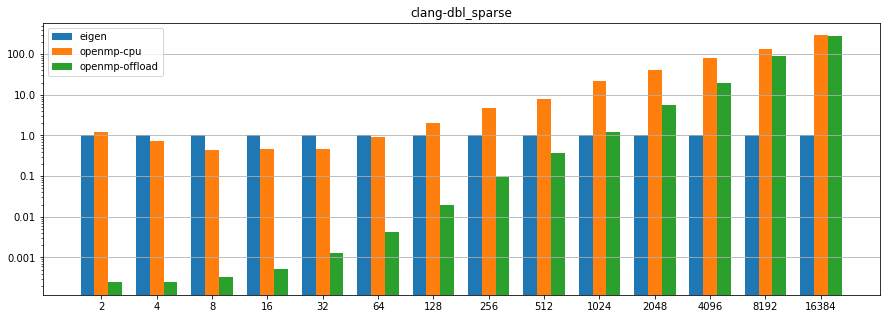

path does not exist:  ../results/gcc-offload-dbl_eigen_triangle_2048_double
path does not exist:  ../results/gcc-offload-dbl_eigen_triangle_4096_double
path does not exist:  ../results/gcc-offload-dbl_eigen_triangle_8192_double
path does not exist:  ../results/gcc-offload-dbl_eigen_triangle_16384_double
path does not exist:  ../results/gcc-offload-dbl_openmp-cpu_triangle_2048_double
path does not exist:  ../results/gcc-offload-dbl_openmp-cpu_triangle_4096_double
path does not exist:  ../results/gcc-offload-dbl_openmp-cpu_triangle_8192_double
path does not exist:  ../results/gcc-offload-dbl_openmp-cpu_triangle_16384_double
path does not exist:  ../results/gcc-offload-dbl_openmp-offload_triangle_2048_double
path does not exist:  ../results/gcc-offload-dbl_openmp-offload_triangle_4096_double
path does not exist:  ../results/gcc-offload-dbl_openmp-offload_triangle_8192_double
path does not exist:  ../results/gcc-offload-dbl_openmp-offload_triangle_16384_double


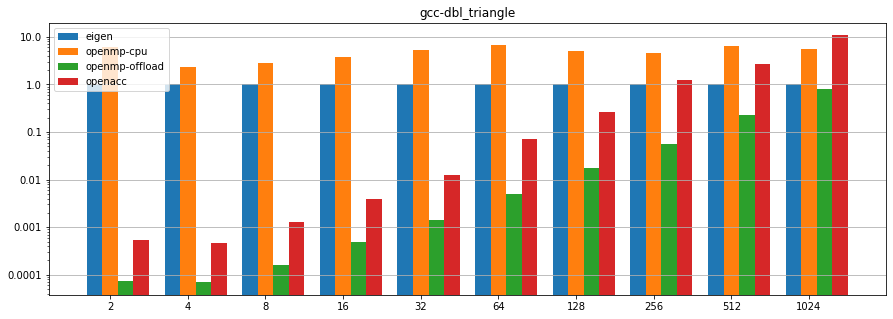

path does not exist:  ../results/nvcc-offload-dbl_cublas_triangle_2048_double
path does not exist:  ../results/nvcc-offload-dbl_cublas_triangle_4096_double
path does not exist:  ../results/nvcc-offload-dbl_cublas_triangle_8192_double
path does not exist:  ../results/nvcc-offload-dbl_cublas_triangle_16384_double


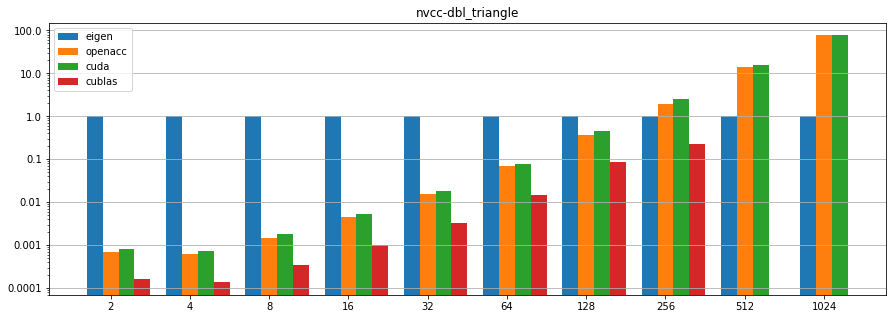

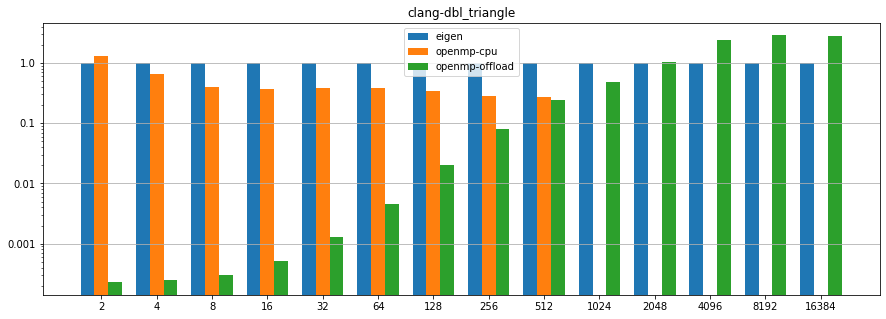

In [293]:
for dbl in [0, 1]:
    for typ in types:
        data = []
        
        ext = "-dbl" if dbl else ""
        
        for alg in algorithms_gcc:
            data.append([process_timings("gcc-offload", alg, typ, dbl), alg])
        data.append([process_timings("gcc-offload-acc", "openacc", typ, dbl), "openacc"])
        base = data.pop(0)
        plot_speedup(base, data, "gcc" + ext + "_" + typ)

        data = []
        for alg in algorithms_nvcc:
            data.append([process_timings("nvcc-offload", alg, typ, dbl), alg])
        plot_speedup(base, data, "nvcc" + ext + "_" + typ)
        
        data = []
        for alg in algorithms_gcc:
            data.append([process_timings("clang-offload", alg, typ, dbl), alg])
        base = data.pop(0)
        plot_speedup(base, data, "clang" + ext + "_" + typ)

file is empty:  ../results/gcc-offload_eigen_normal_8192
file is empty:  ../results/gcc-offload_eigen_normal_16384


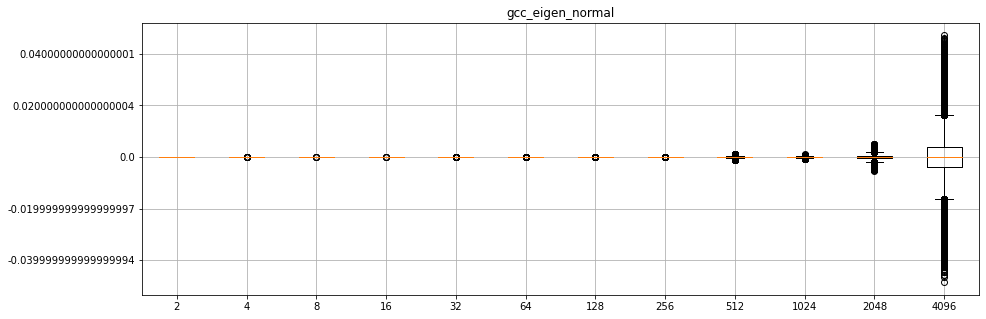

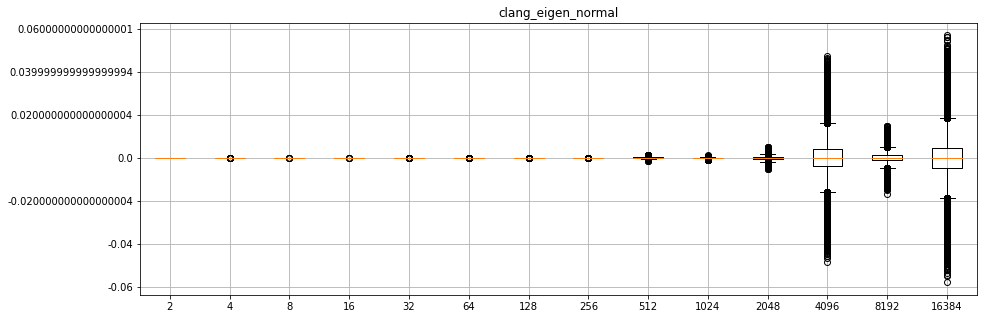

path does not exist:  ../results/gcc-offload_openmp-cpu_normal_2048
path does not exist:  ../results/gcc-offload_openmp-cpu_normal_4096
path does not exist:  ../results/gcc-offload_openmp-cpu_normal_8192
path does not exist:  ../results/gcc-offload_openmp-cpu_normal_16384


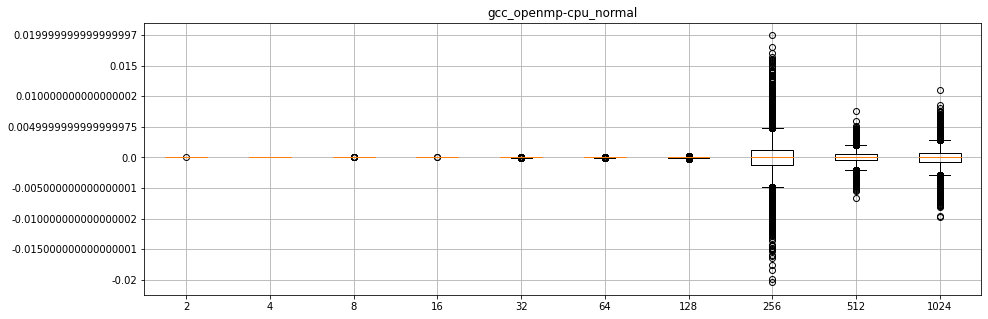

file is empty:  ../results/clang-offload_openmp-cpu_normal_1024
file is empty:  ../results/clang-offload_openmp-cpu_normal_2048
file is empty:  ../results/clang-offload_openmp-cpu_normal_4096
file is empty:  ../results/clang-offload_openmp-cpu_normal_8192
file is empty:  ../results/clang-offload_openmp-cpu_normal_16384


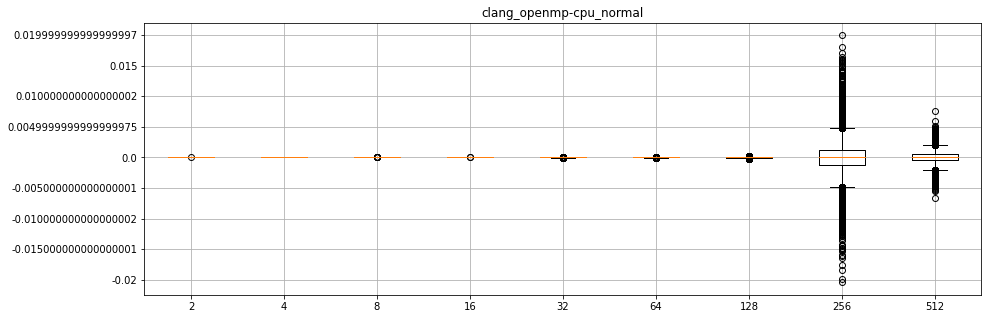

path does not exist:  ../results/gcc-offload_openmp-offload_normal_2048
path does not exist:  ../results/gcc-offload_openmp-offload_normal_4096
path does not exist:  ../results/gcc-offload_openmp-offload_normal_8192
path does not exist:  ../results/gcc-offload_openmp-offload_normal_16384


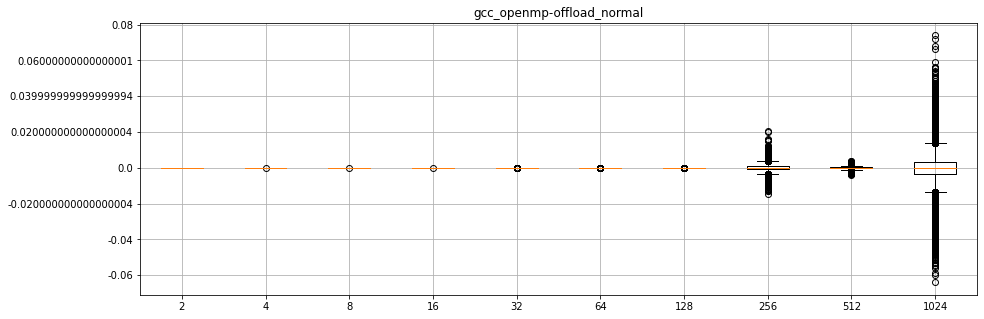

path does not exist:  ../results/clang-offload_openmp-offload_normal_2048
path does not exist:  ../results/clang-offload_openmp-offload_normal_4096
path does not exist:  ../results/clang-offload_openmp-offload_normal_8192
path does not exist:  ../results/clang-offload_openmp-offload_normal_16384


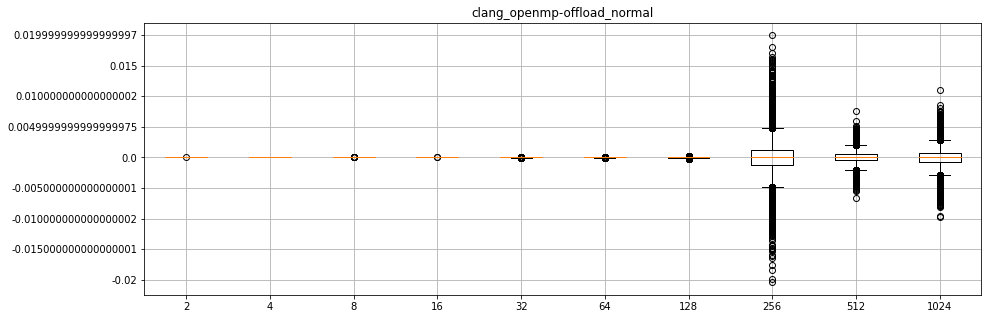

121122641 121122969 
NaN or abrupts ending:  ../results/gcc-offload-acc_openacc_normal_16384


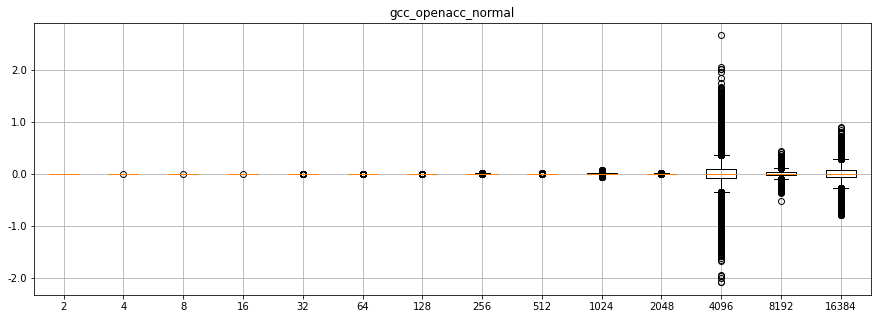

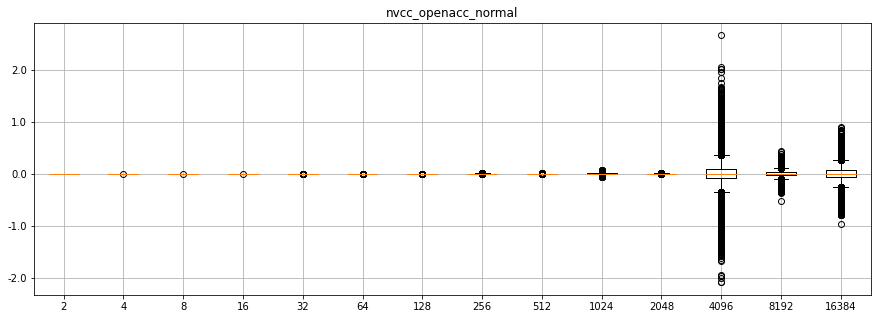

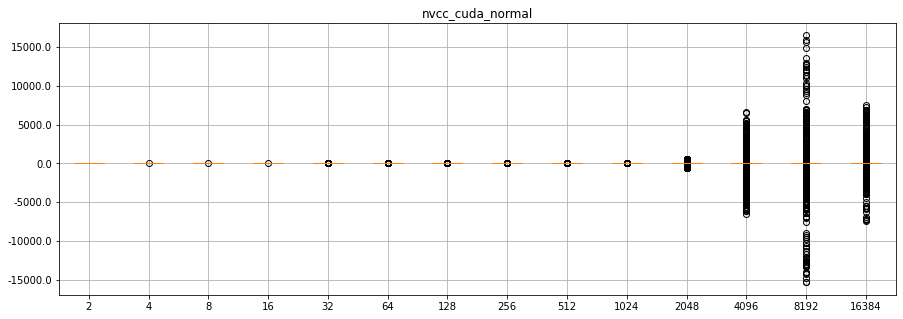

NaN or abrupts ending:  ../results/nvcc-offload_cublas_normal_256
file is empty:  ../results/nvcc-offload_cublas_normal_512
file is empty:  ../results/nvcc-offload_cublas_normal_1024
file is empty:  ../results/nvcc-offload_cublas_normal_2048
file is empty:  ../results/nvcc-offload_cublas_normal_4096
file is empty:  ../results/nvcc-offload_cublas_normal_8192
file is empty:  ../results/nvcc-offload_cublas_normal_16384


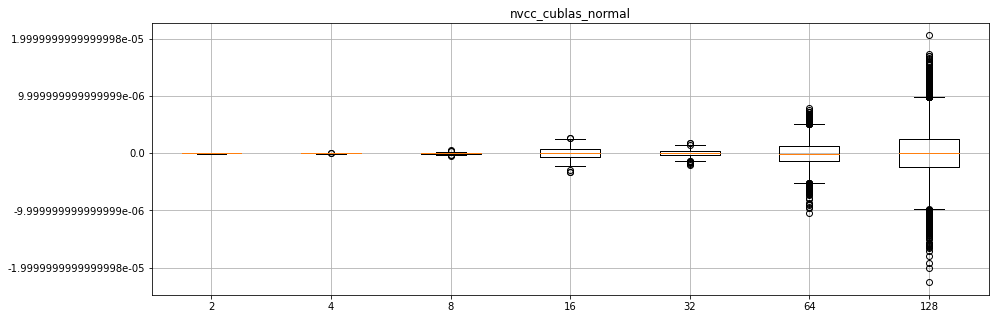

path does not exist:  ../results/nvcc-offload_openmp-offload_normal_2048
path does not exist:  ../results/nvcc-offload_openmp-offload_normal_4096
path does not exist:  ../results/nvcc-offload_openmp-offload_normal_8192
path does not exist:  ../results/nvcc-offload_openmp-offload_normal_16384


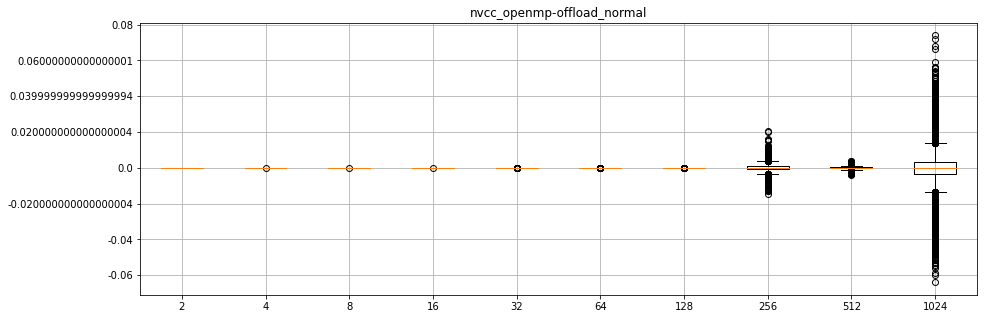

file is empty:  ../results/gcc-offload_eigen_natural_4096
path does not exist:  ../results/gcc-offload_eigen_natural_8192
path does not exist:  ../results/gcc-offload_eigen_natural_16384


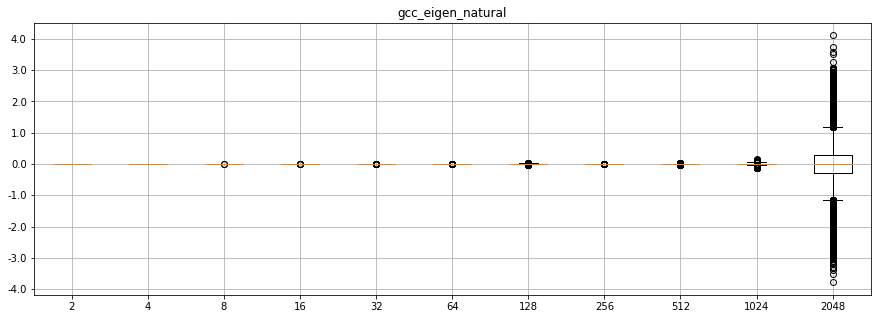

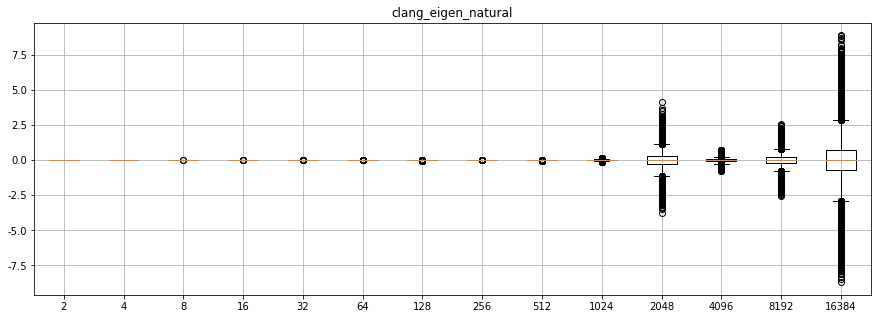

path does not exist:  ../results/gcc-offload_openmp-cpu_natural_2048
path does not exist:  ../results/gcc-offload_openmp-cpu_natural_4096
path does not exist:  ../results/gcc-offload_openmp-cpu_natural_8192
path does not exist:  ../results/gcc-offload_openmp-cpu_natural_16384


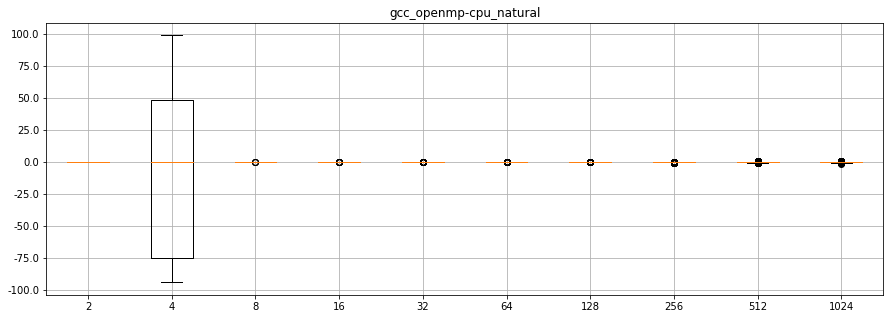

file is empty:  ../results/clang-offload_openmp-cpu_natural_1024
file is empty:  ../results/clang-offload_openmp-cpu_natural_2048
file is empty:  ../results/clang-offload_openmp-cpu_natural_4096
file is empty:  ../results/clang-offload_openmp-cpu_natural_8192
file is empty:  ../results/clang-offload_openmp-cpu_natural_16384


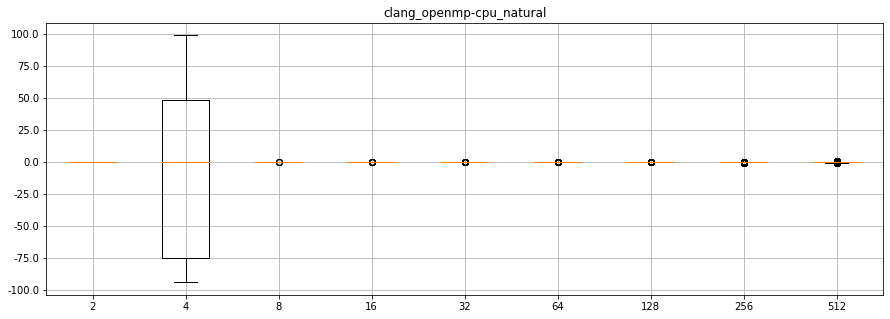

NaN or abrupts ending:  ../results/gcc-offload_openmp-offload_natural_4
3071 3072 NaN

NaN or abrupts ending:  ../results/gcc-offload_openmp-offload_natural_256
227327 227328 NaN

NaN or abrupts ending:  ../results/gcc-offload_openmp-offload_natural_512
76799 76800 NaN

NaN or abrupts ending:  ../results/gcc-offload_openmp-offload_natural_1024
path does not exist:  ../results/gcc-offload_openmp-offload_natural_2048
path does not exist:  ../results/gcc-offload_openmp-offload_natural_4096
path does not exist:  ../results/gcc-offload_openmp-offload_natural_8192
path does not exist:  ../results/gcc-offload_openmp-offload_natural_16384


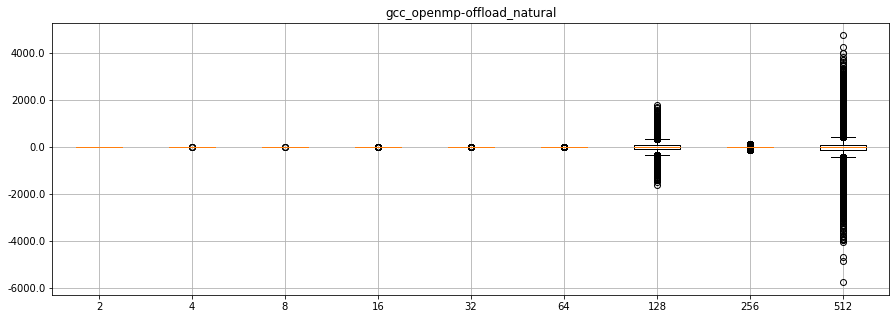

NaN or abrupts ending:  ../results/clang-offload_openmp-offload_natural_4
3071 3072 NaN

NaN or abrupts ending:  ../results/clang-offload_openmp-offload_natural_256
227327 227328 NaN

NaN or abrupts ending:  ../results/clang-offload_openmp-offload_natural_512
76799 76800 NaN

NaN or abrupts ending:  ../results/clang-offload_openmp-offload_natural_1024
path does not exist:  ../results/clang-offload_openmp-offload_natural_2048
path does not exist:  ../results/clang-offload_openmp-offload_natural_4096
path does not exist:  ../results/clang-offload_openmp-offload_natural_8192
path does not exist:  ../results/clang-offload_openmp-offload_natural_16384


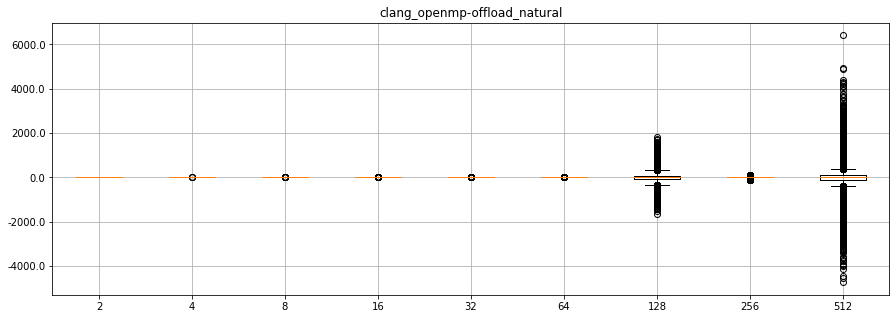

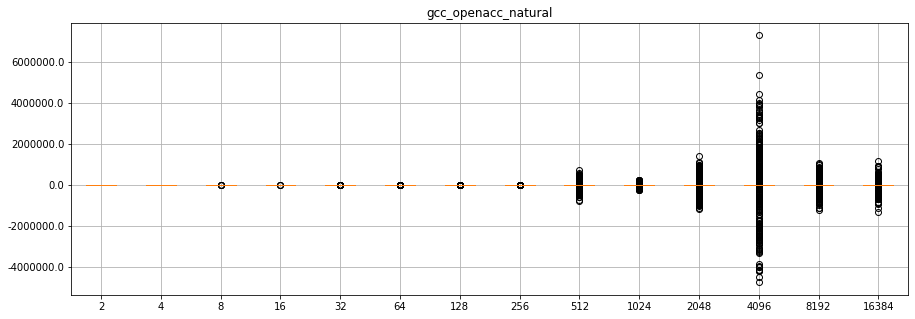

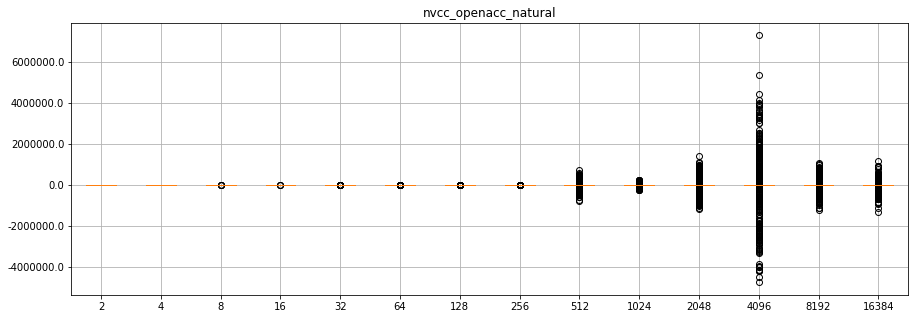

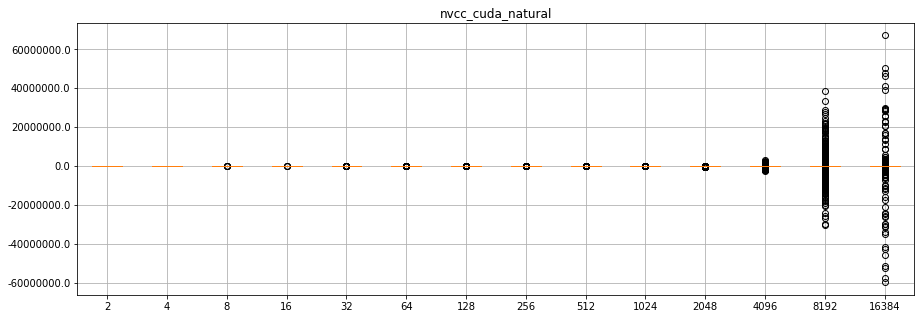

NaN or abrupts ending:  ../results/nvcc-offload_cublas_natural_256
file is empty:  ../results/nvcc-offload_cublas_natural_512
file is empty:  ../results/nvcc-offload_cublas_natural_1024
file is empty:  ../results/nvcc-offload_cublas_natural_2048
file is empty:  ../results/nvcc-offload_cublas_natural_4096
file is empty:  ../results/nvcc-offload_cublas_natural_8192
file is empty:  ../results/nvcc-offload_cublas_natural_16384


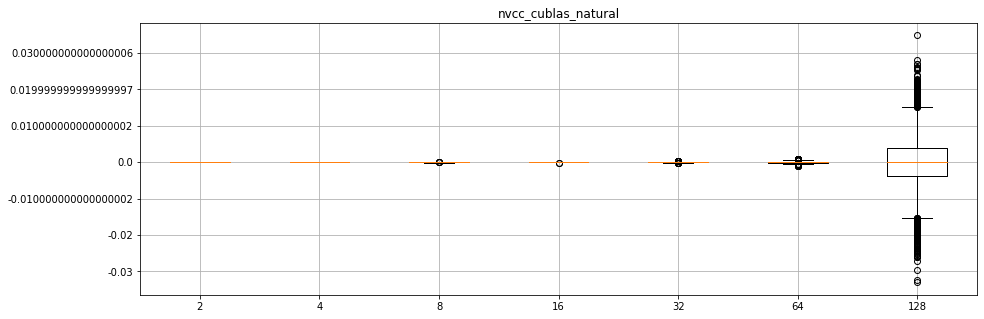

NaN or abrupts ending:  ../results/nvcc-offload_openmp-offload_natural_4
path does not exist:  ../results/nvcc-offload_openmp-offload_natural_2048
path does not exist:  ../results/nvcc-offload_openmp-offload_natural_4096
path does not exist:  ../results/nvcc-offload_openmp-offload_natural_8192
path does not exist:  ../results/nvcc-offload_openmp-offload_natural_16384


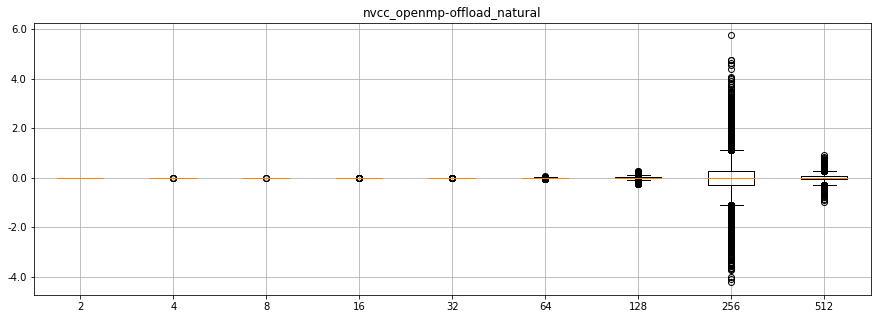

path does not exist:  ../results/gcc-offload_eigen_sparse_2048
path does not exist:  ../results/gcc-offload_eigen_sparse_4096
path does not exist:  ../results/gcc-offload_eigen_sparse_8192
path does not exist:  ../results/gcc-offload_eigen_sparse_16384


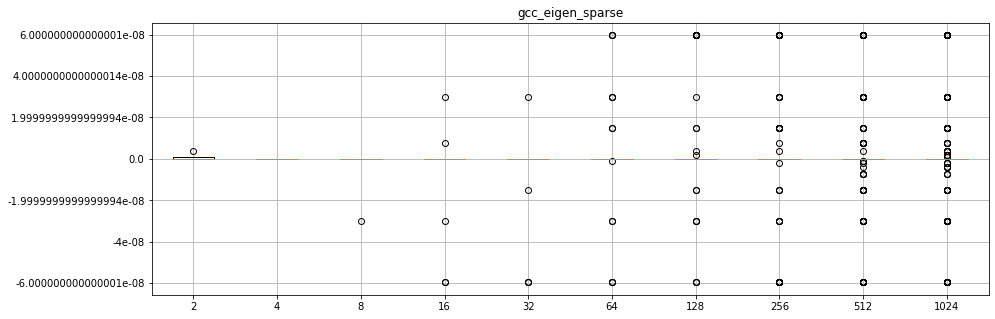

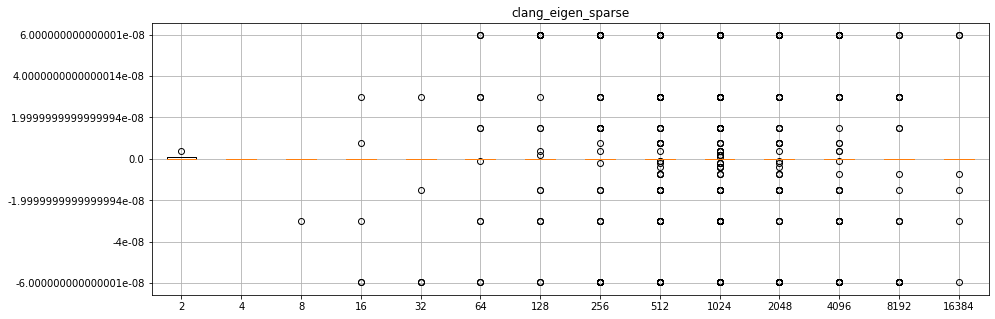

path does not exist:  ../results/gcc-offload_openmp-cpu_sparse_2048
path does not exist:  ../results/gcc-offload_openmp-cpu_sparse_4096
path does not exist:  ../results/gcc-offload_openmp-cpu_sparse_8192
path does not exist:  ../results/gcc-offload_openmp-cpu_sparse_16384


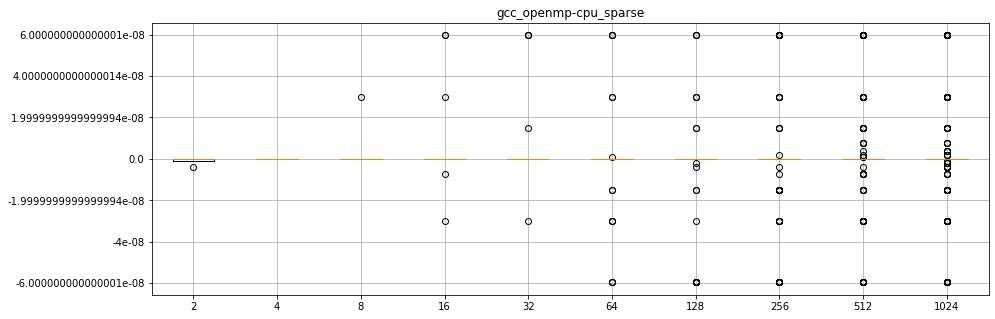

path does not exist:  ../results/clang-offload_openmp-cpu_sparse_2048
path does not exist:  ../results/clang-offload_openmp-cpu_sparse_4096
path does not exist:  ../results/clang-offload_openmp-cpu_sparse_8192
path does not exist:  ../results/clang-offload_openmp-cpu_sparse_16384


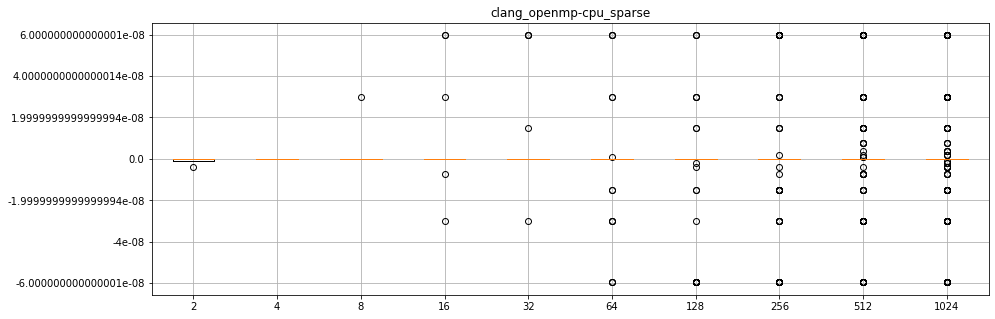

path does not exist:  ../results/gcc-offload_openmp-offload_sparse_2048
path does not exist:  ../results/gcc-offload_openmp-offload_sparse_4096
path does not exist:  ../results/gcc-offload_openmp-offload_sparse_8192
path does not exist:  ../results/gcc-offload_openmp-offload_sparse_16384


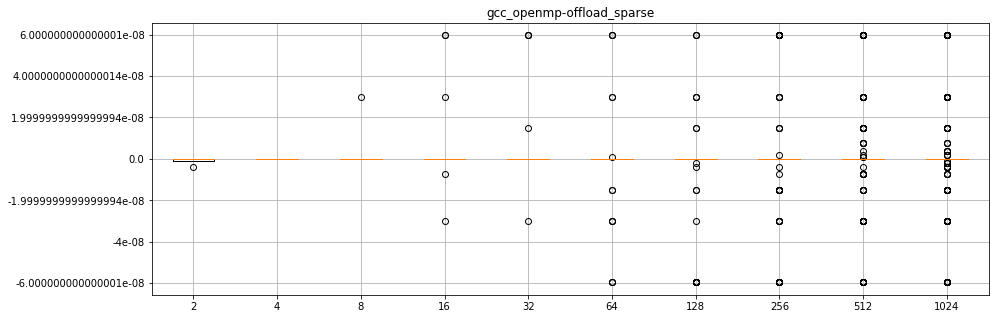

path does not exist:  ../results/clang-offload_openmp-offload_sparse_2048
path does not exist:  ../results/clang-offload_openmp-offload_sparse_4096
path does not exist:  ../results/clang-offload_openmp-offload_sparse_8192
path does not exist:  ../results/clang-offload_openmp-offload_sparse_16384


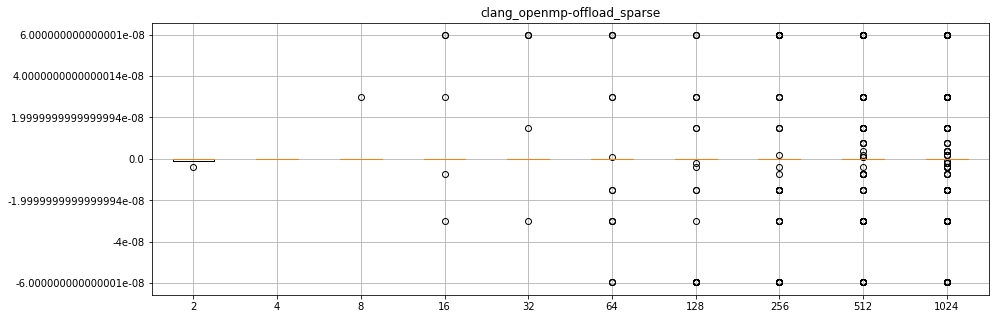

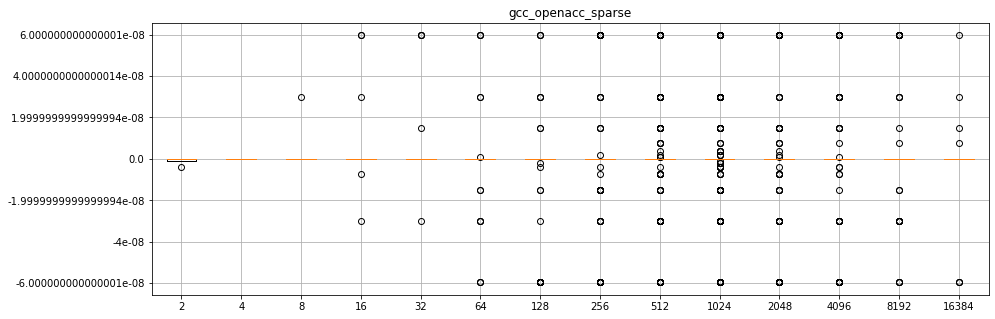

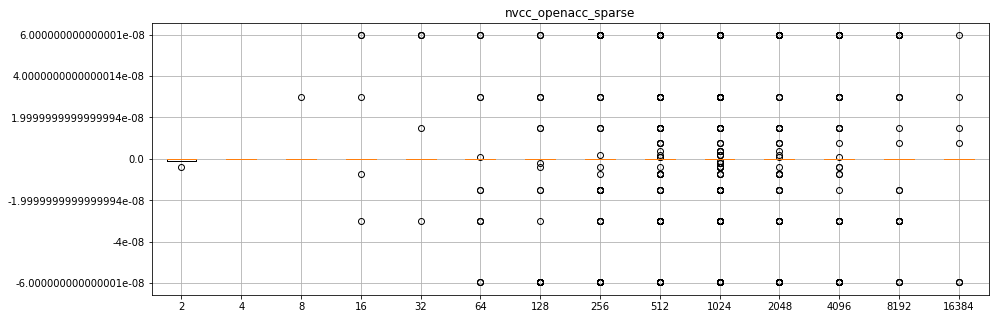

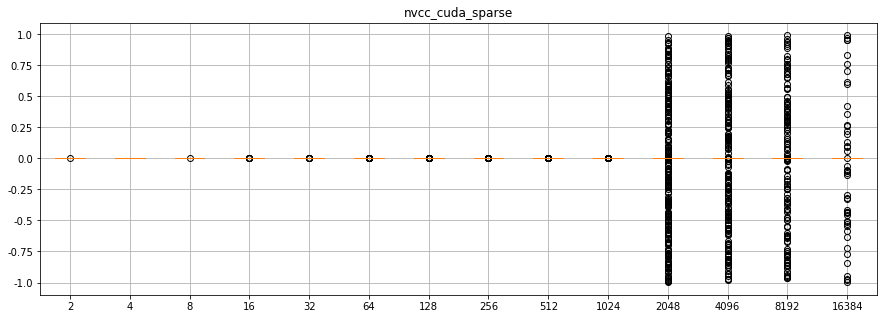

NaN or abrupts ending:  ../results/nvcc-offload_cublas_sparse_256
file is empty:  ../results/nvcc-offload_cublas_sparse_512
file is empty:  ../results/nvcc-offload_cublas_sparse_1024
file is empty:  ../results/nvcc-offload_cublas_sparse_2048
file is empty:  ../results/nvcc-offload_cublas_sparse_4096
file is empty:  ../results/nvcc-offload_cublas_sparse_8192
file is empty:  ../results/nvcc-offload_cublas_sparse_16384


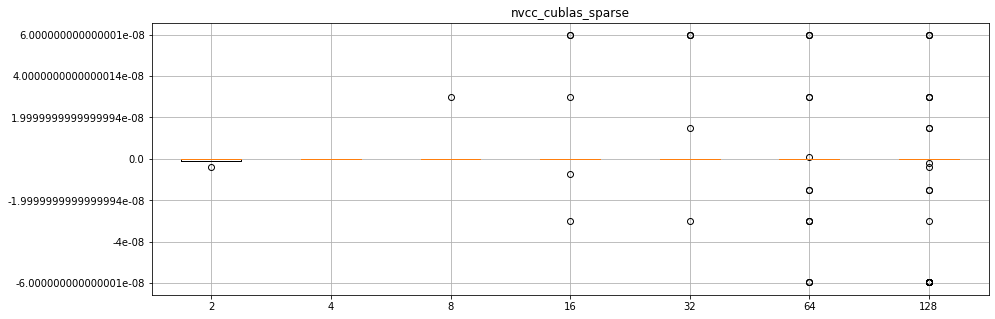

path does not exist:  ../results/nvcc-offload_openmp-offload_sparse_2048
path does not exist:  ../results/nvcc-offload_openmp-offload_sparse_4096
path does not exist:  ../results/nvcc-offload_openmp-offload_sparse_8192
path does not exist:  ../results/nvcc-offload_openmp-offload_sparse_16384


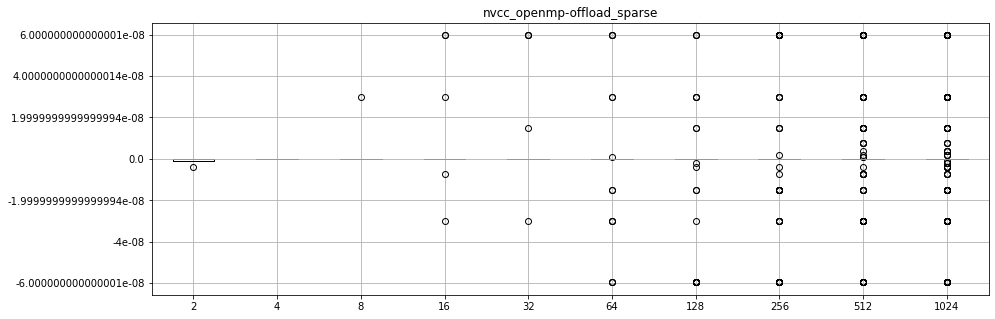

path does not exist:  ../results/gcc-offload_eigen_triangle_2048
path does not exist:  ../results/gcc-offload_eigen_triangle_4096
path does not exist:  ../results/gcc-offload_eigen_triangle_8192
path does not exist:  ../results/gcc-offload_eigen_triangle_16384


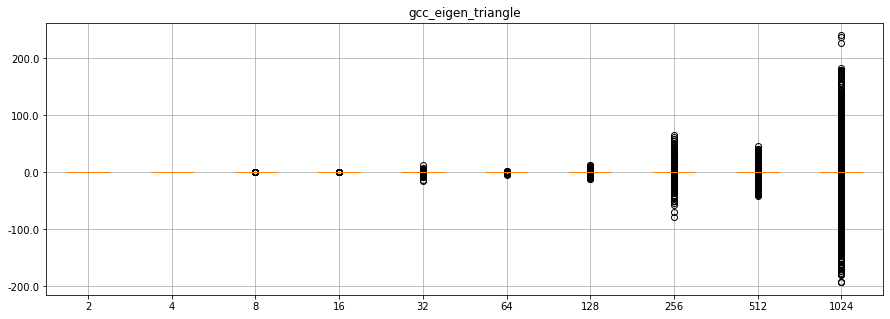

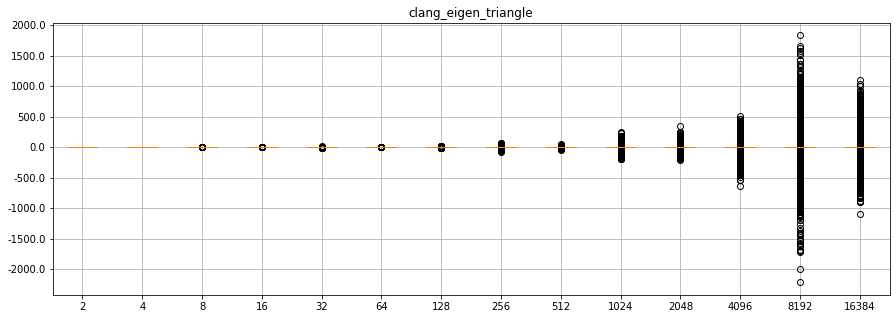

NaN or abrupts ending:  ../results/gcc-offload_openmp-cpu_triangle_256
NaN or abrupts ending:  ../results/gcc-offload_openmp-cpu_triangle_512
NaN or abrupts ending:  ../results/gcc-offload_openmp-cpu_triangle_1024
path does not exist:  ../results/gcc-offload_openmp-cpu_triangle_2048
path does not exist:  ../results/gcc-offload_openmp-cpu_triangle_4096
path does not exist:  ../results/gcc-offload_openmp-cpu_triangle_8192
path does not exist:  ../results/gcc-offload_openmp-cpu_triangle_16384


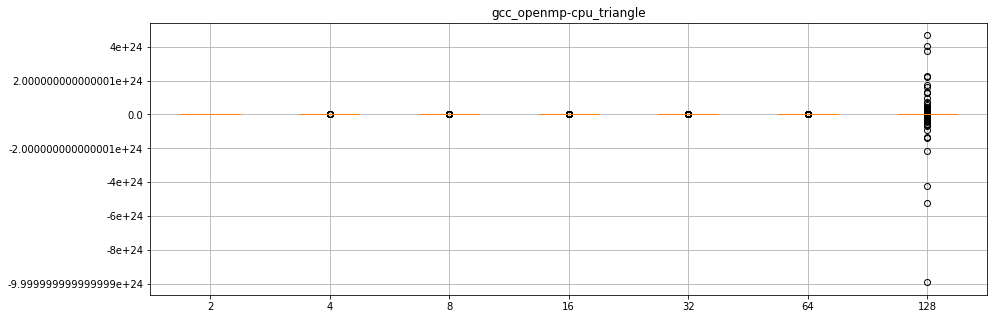

NaN or abrupts ending:  ../results/clang-offload_openmp-cpu_triangle_256
NaN or abrupts ending:  ../results/clang-offload_openmp-cpu_triangle_512
file is empty:  ../results/clang-offload_openmp-cpu_triangle_1024
path does not exist:  ../results/clang-offload_openmp-cpu_triangle_2048
path does not exist:  ../results/clang-offload_openmp-cpu_triangle_4096
path does not exist:  ../results/clang-offload_openmp-cpu_triangle_8192
path does not exist:  ../results/clang-offload_openmp-cpu_triangle_16384


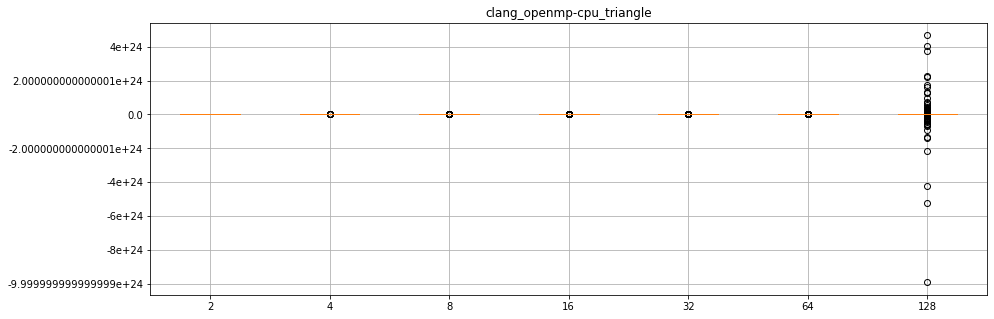

NaN or abrupts ending:  ../results/gcc-offload_openmp-offload_triangle_256
NaN or abrupts ending:  ../results/gcc-offload_openmp-offload_triangle_512
NaN or abrupts ending:  ../results/gcc-offload_openmp-offload_triangle_1024
path does not exist:  ../results/gcc-offload_openmp-offload_triangle_2048
path does not exist:  ../results/gcc-offload_openmp-offload_triangle_4096
path does not exist:  ../results/gcc-offload_openmp-offload_triangle_8192
path does not exist:  ../results/gcc-offload_openmp-offload_triangle_16384


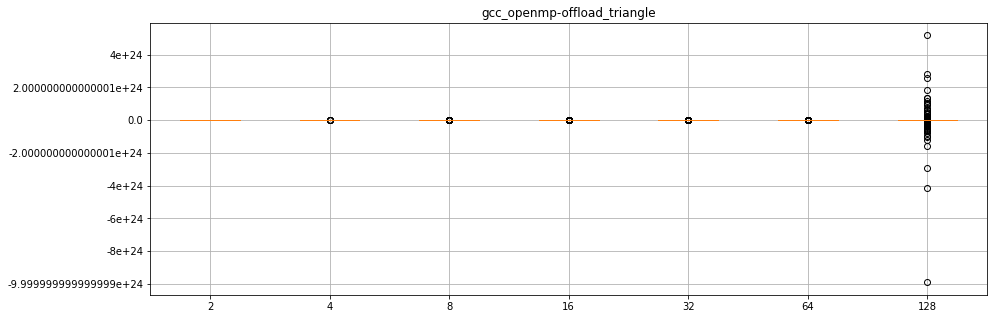

NaN or abrupts ending:  ../results/clang-offload_openmp-offload_triangle_256
NaN or abrupts ending:  ../results/clang-offload_openmp-offload_triangle_512
NaN or abrupts ending:  ../results/clang-offload_openmp-offload_triangle_1024
path does not exist:  ../results/clang-offload_openmp-offload_triangle_2048
path does not exist:  ../results/clang-offload_openmp-offload_triangle_4096
path does not exist:  ../results/clang-offload_openmp-offload_triangle_8192
path does not exist:  ../results/clang-offload_openmp-offload_triangle_16384


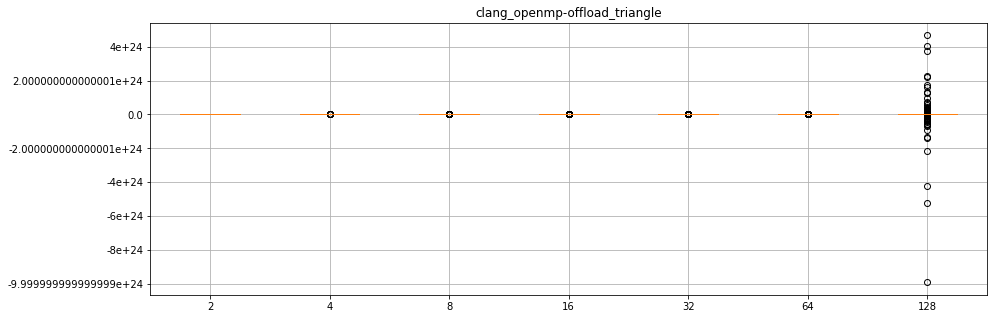

NaN or abrupts ending:  ../results/gcc-offload-acc_openacc_triangle_256
NaN or abrupts ending:  ../results/gcc-offload-acc_openacc_triangle_512
NaN or abrupts ending:  ../results/gcc-offload-acc_openacc_triangle_1024
0 7 
NaN or abrupts ending:  ../results/gcc-offload-acc_openacc_triangle_2048
NaN or abrupts ending:  ../results/gcc-offload-acc_openacc_triangle_4096
0 34 
NaN or abrupts ending:  ../results/gcc-offload-acc_openacc_triangle_8192
0 395 
NaN or abrupts ending:  ../results/gcc-offload-acc_openacc_triangle_16384


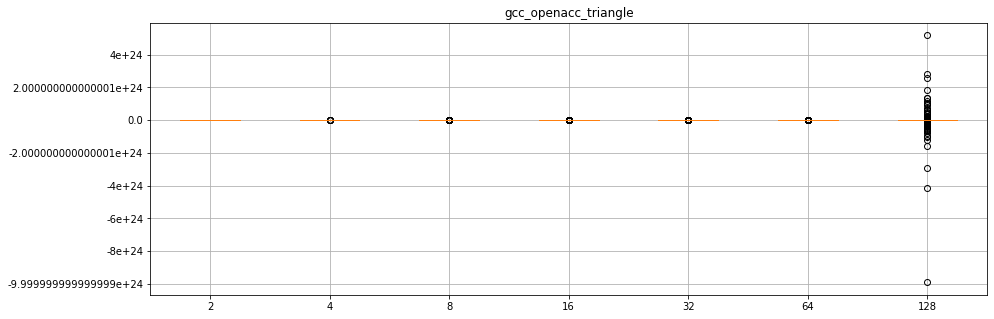

NaN or abrupts ending:  ../results/nvcc-offload_openacc_triangle_256
NaN or abrupts ending:  ../results/nvcc-offload_openacc_triangle_512
NaN or abrupts ending:  ../results/nvcc-offload_openacc_triangle_1024
0 7 
NaN or abrupts ending:  ../results/nvcc-offload_openacc_triangle_2048
NaN or abrupts ending:  ../results/nvcc-offload_openacc_triangle_4096
0 34 
NaN or abrupts ending:  ../results/nvcc-offload_openacc_triangle_8192
0 395 
NaN or abrupts ending:  ../results/nvcc-offload_openacc_triangle_16384


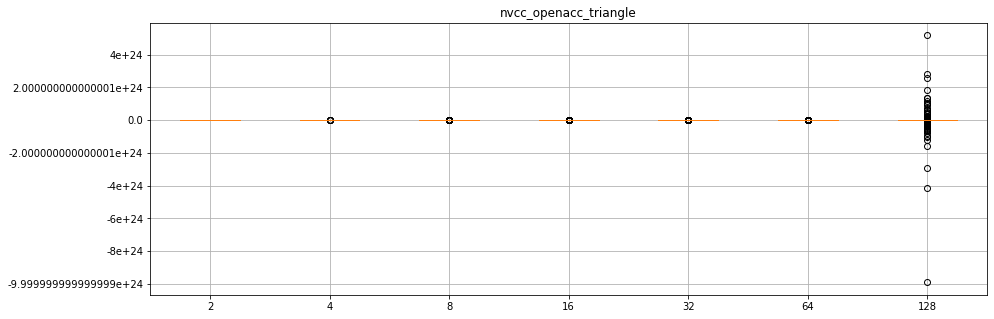

NaN or abrupts ending:  ../results/nvcc-offload_cuda_triangle_256
NaN or abrupts ending:  ../results/nvcc-offload_cuda_triangle_512
NaN or abrupts ending:  ../results/nvcc-offload_cuda_triangle_1024
0 7 
NaN or abrupts ending:  ../results/nvcc-offload_cuda_triangle_2048
NaN or abrupts ending:  ../results/nvcc-offload_cuda_triangle_4096
0 34 
NaN or abrupts ending:  ../results/nvcc-offload_cuda_triangle_8192
0 395 
NaN or abrupts ending:  ../results/nvcc-offload_cuda_triangle_16384


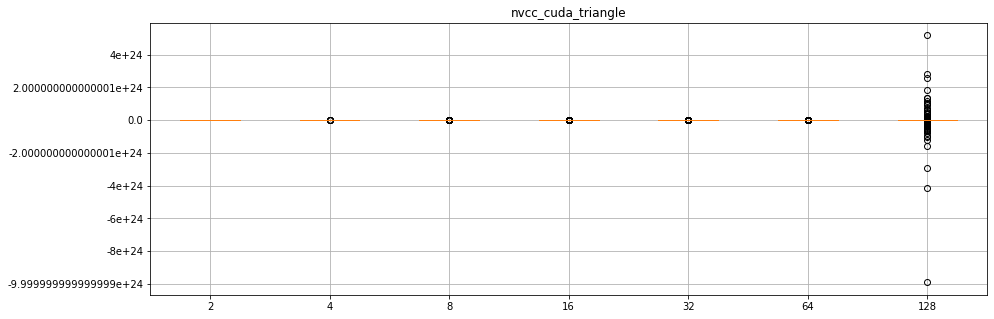

NaN or abrupts ending:  ../results/nvcc-offload_cublas_triangle_256
file is empty:  ../results/nvcc-offload_cublas_triangle_512
file is empty:  ../results/nvcc-offload_cublas_triangle_1024
file is empty:  ../results/nvcc-offload_cublas_triangle_2048
file is empty:  ../results/nvcc-offload_cublas_triangle_4096
file is empty:  ../results/nvcc-offload_cublas_triangle_8192
file is empty:  ../results/nvcc-offload_cublas_triangle_16384


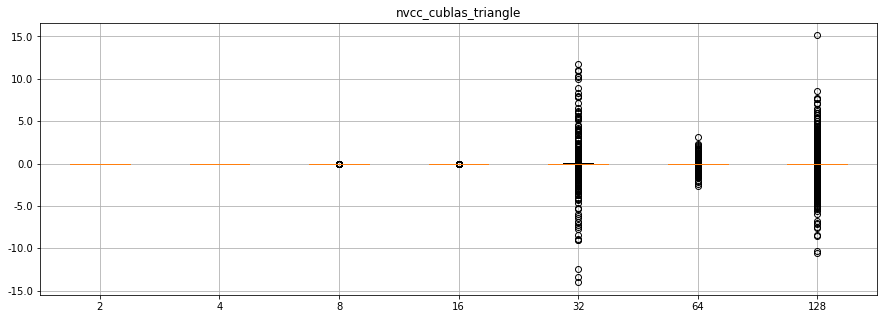

NaN or abrupts ending:  ../results/nvcc-offload_openmp-offload_triangle_256
NaN or abrupts ending:  ../results/nvcc-offload_openmp-offload_triangle_512
NaN or abrupts ending:  ../results/nvcc-offload_openmp-offload_triangle_1024
path does not exist:  ../results/nvcc-offload_openmp-offload_triangle_2048
path does not exist:  ../results/nvcc-offload_openmp-offload_triangle_4096
path does not exist:  ../results/nvcc-offload_openmp-offload_triangle_8192
path does not exist:  ../results/nvcc-offload_openmp-offload_triangle_16384


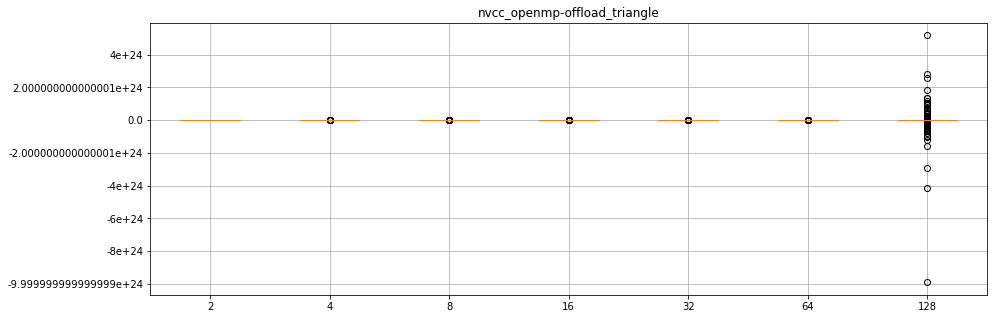

file is empty:  ../results/gcc-offload-dbl_eigen_normal_8192_double
file is empty:  ../results/gcc-offload-dbl_eigen_normal_16384_double


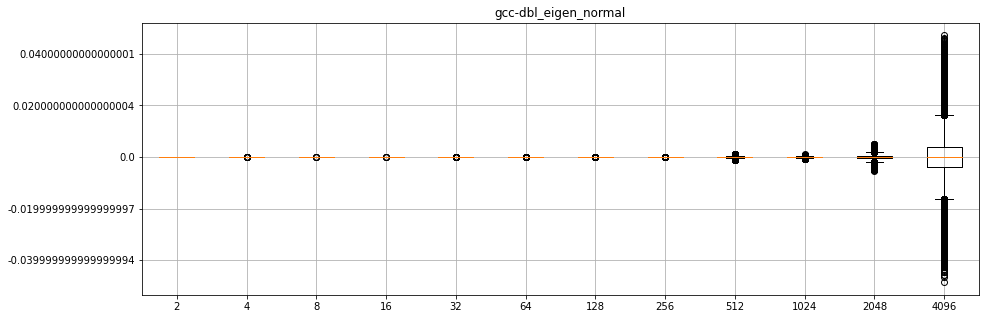

114182829 114182931 
NaN or abrupts ending:  ../results/clang-offload-dbl_eigen_normal_16384_double


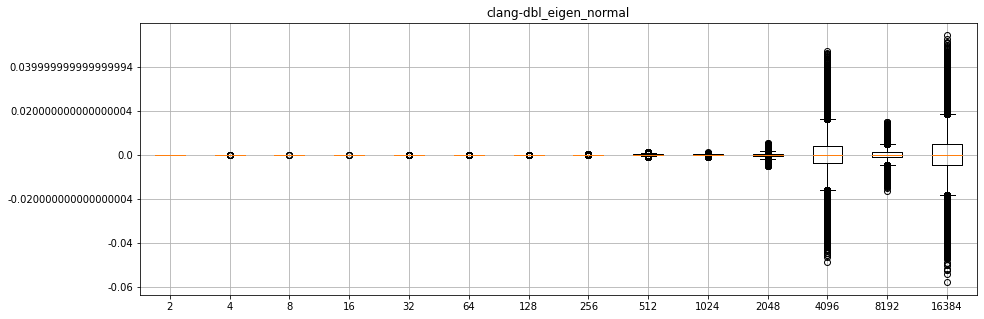

path does not exist:  ../results/gcc-offload-dbl_openmp-cpu_normal_2048_double
path does not exist:  ../results/gcc-offload-dbl_openmp-cpu_normal_4096_double
path does not exist:  ../results/gcc-offload-dbl_openmp-cpu_normal_8192_double
path does not exist:  ../results/gcc-offload-dbl_openmp-cpu_normal_16384_double


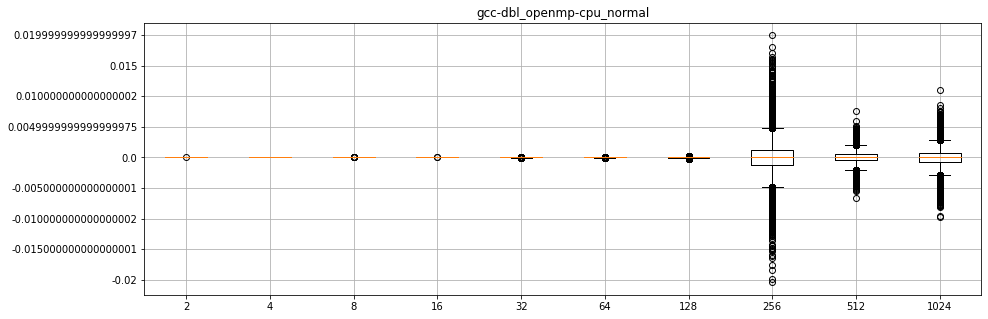

file is empty:  ../results/clang-offload-dbl_openmp-cpu_normal_1024_double
file is empty:  ../results/clang-offload-dbl_openmp-cpu_normal_2048_double
file is empty:  ../results/clang-offload-dbl_openmp-cpu_normal_4096_double
file is empty:  ../results/clang-offload-dbl_openmp-cpu_normal_8192_double
file is empty:  ../results/clang-offload-dbl_openmp-cpu_normal_16384_double


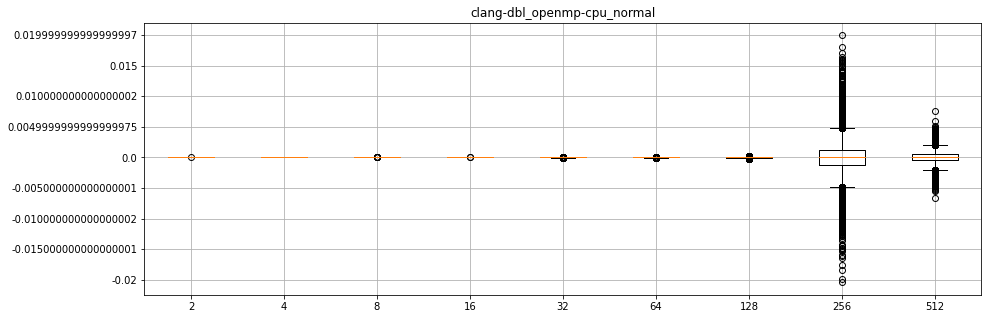

path does not exist:  ../results/gcc-offload-dbl_openmp-offload_normal_2048_double
path does not exist:  ../results/gcc-offload-dbl_openmp-offload_normal_4096_double
path does not exist:  ../results/gcc-offload-dbl_openmp-offload_normal_8192_double
path does not exist:  ../results/gcc-offload-dbl_openmp-offload_normal_16384_double


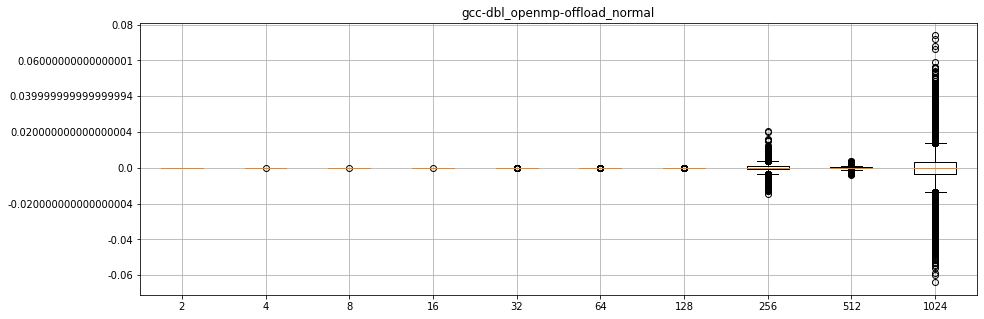

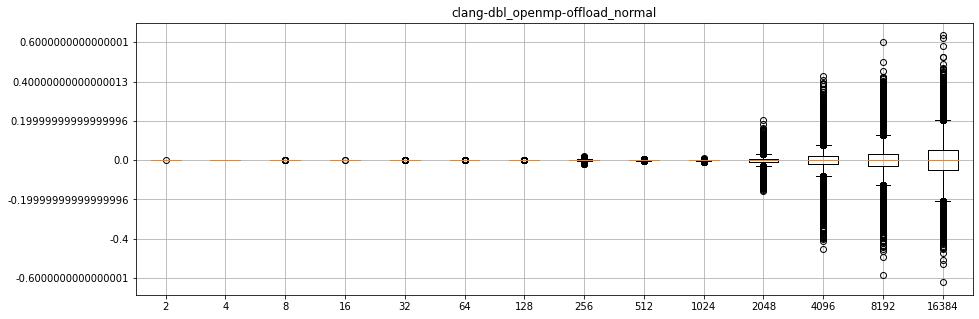

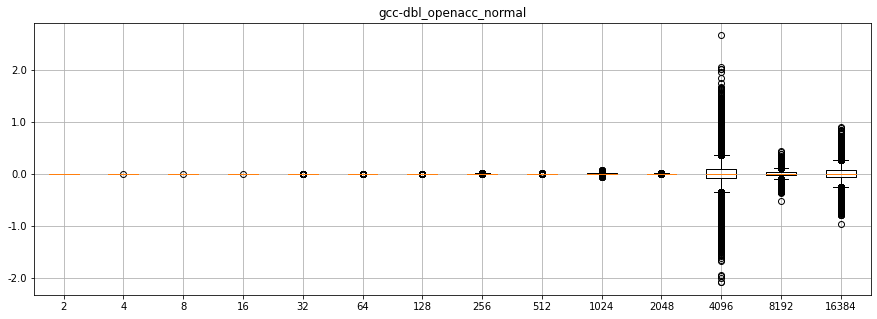

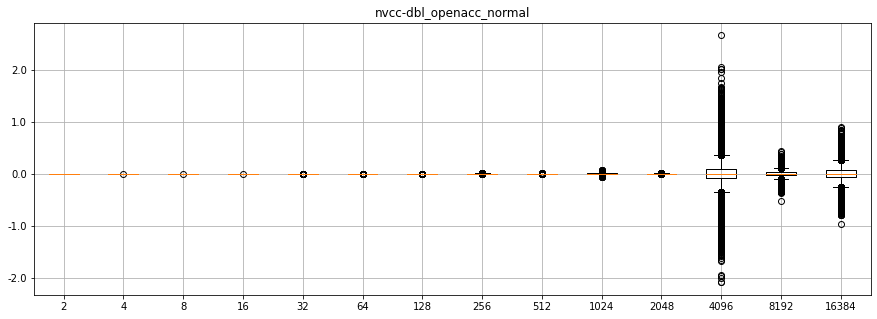

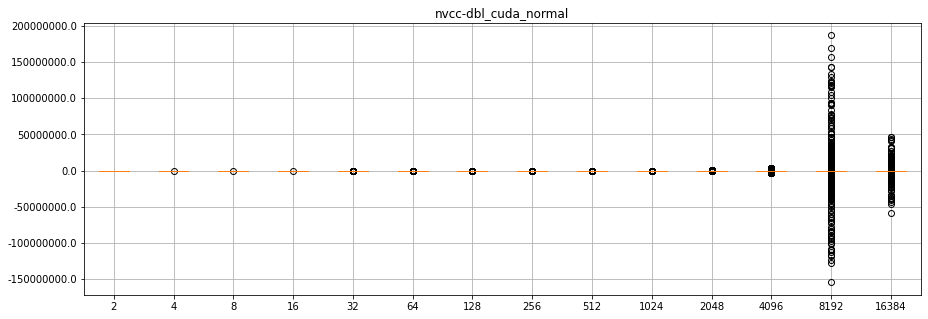

NaN or abrupts ending:  ../results/nvcc-offload-dbl_cublas_normal_256_double
file is empty:  ../results/nvcc-offload-dbl_cublas_normal_512_double
file is empty:  ../results/nvcc-offload-dbl_cublas_normal_1024_double
path does not exist:  ../results/nvcc-offload-dbl_cublas_normal_2048_double
path does not exist:  ../results/nvcc-offload-dbl_cublas_normal_4096_double
path does not exist:  ../results/nvcc-offload-dbl_cublas_normal_8192_double
path does not exist:  ../results/nvcc-offload-dbl_cublas_normal_16384_double


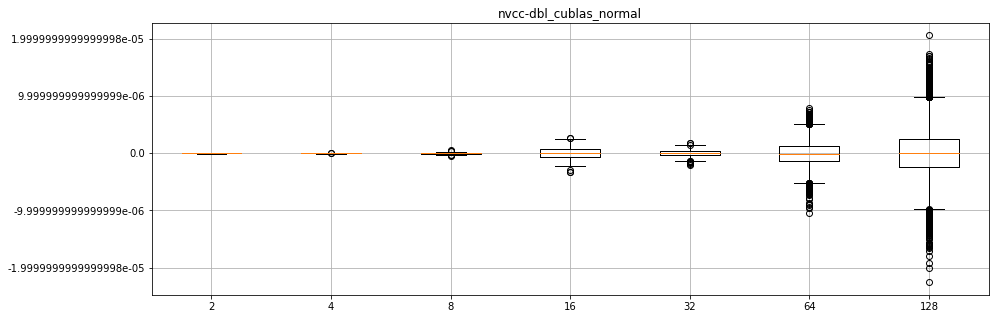

path does not exist:  ../results/nvcc-offload-dbl_openmp-offload_normal_2048_double
path does not exist:  ../results/nvcc-offload-dbl_openmp-offload_normal_4096_double
path does not exist:  ../results/nvcc-offload-dbl_openmp-offload_normal_8192_double
path does not exist:  ../results/nvcc-offload-dbl_openmp-offload_normal_16384_double


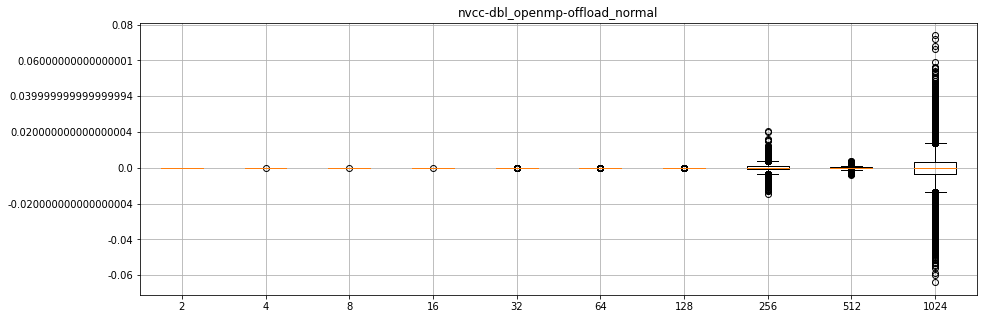

file is empty:  ../results/gcc-offload-dbl_eigen_natural_16384_double


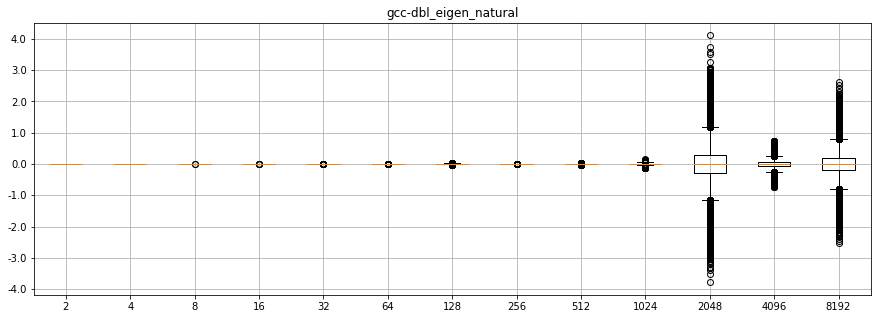

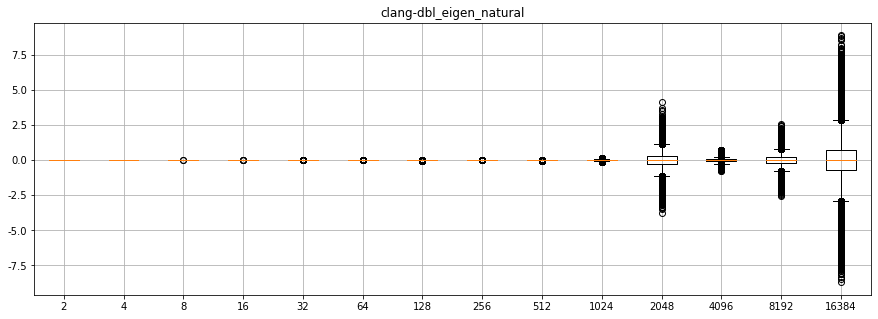

path does not exist:  ../results/gcc-offload-dbl_openmp-cpu_natural_2048_double
path does not exist:  ../results/gcc-offload-dbl_openmp-cpu_natural_4096_double
path does not exist:  ../results/gcc-offload-dbl_openmp-cpu_natural_8192_double
path does not exist:  ../results/gcc-offload-dbl_openmp-cpu_natural_16384_double


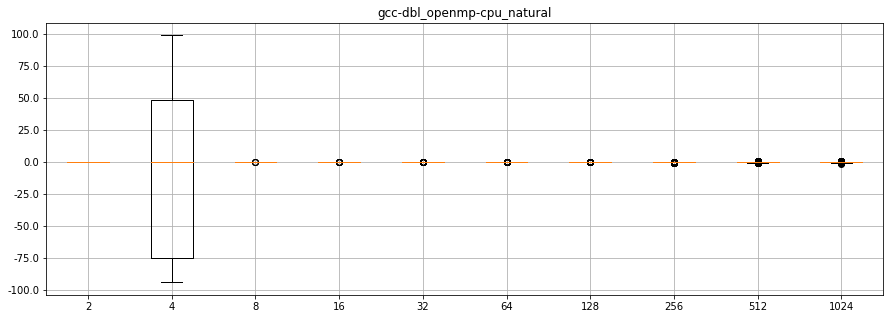

file is empty:  ../results/clang-offload-dbl_openmp-cpu_natural_1024_double
file is empty:  ../results/clang-offload-dbl_openmp-cpu_natural_2048_double
file is empty:  ../results/clang-offload-dbl_openmp-cpu_natural_4096_double
file is empty:  ../results/clang-offload-dbl_openmp-cpu_natural_8192_double
file is empty:  ../results/clang-offload-dbl_openmp-cpu_natural_16384_double


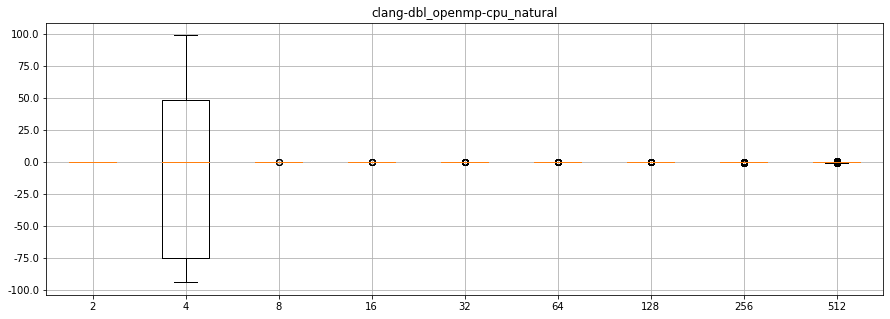

NaN or abrupts ending:  ../results/gcc-offload-dbl_openmp-offload_natural_4_double
3071 3072 NaN

NaN or abrupts ending:  ../results/gcc-offload-dbl_openmp-offload_natural_256_double
227327 227328 NaN

NaN or abrupts ending:  ../results/gcc-offload-dbl_openmp-offload_natural_512_double
76799 76800 NaN

NaN or abrupts ending:  ../results/gcc-offload-dbl_openmp-offload_natural_1024_double
path does not exist:  ../results/gcc-offload-dbl_openmp-offload_natural_2048_double
path does not exist:  ../results/gcc-offload-dbl_openmp-offload_natural_4096_double
path does not exist:  ../results/gcc-offload-dbl_openmp-offload_natural_8192_double
path does not exist:  ../results/gcc-offload-dbl_openmp-offload_natural_16384_double


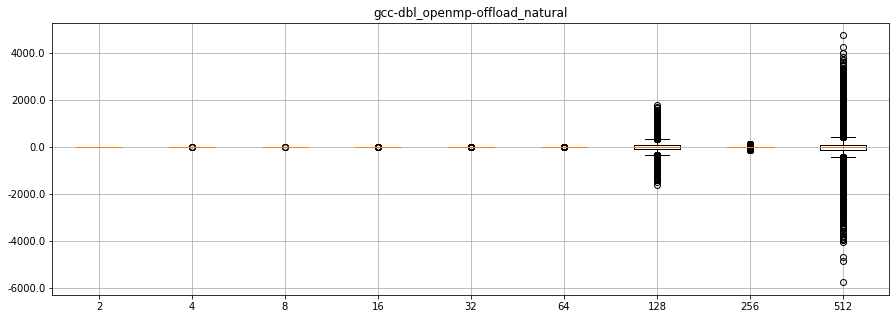

NaN or abrupts ending:  ../results/clang-offload-dbl_openmp-offload_natural_4_double
3071 3072 NaN

NaN or abrupts ending:  ../results/clang-offload-dbl_openmp-offload_natural_256_double
227327 227328 NaN

NaN or abrupts ending:  ../results/clang-offload-dbl_openmp-offload_natural_512_double
76799 76800 NaN

NaN or abrupts ending:  ../results/clang-offload-dbl_openmp-offload_natural_1024_double
356351 356358 NaN

NaN or abrupts ending:  ../results/clang-offload-dbl_openmp-offload_natural_2048_double
851967 851970 NaN

NaN or abrupts ending:  ../results/clang-offload-dbl_openmp-offload_natural_4096_double
3678207 3678302 NaN

NaN or abrupts ending:  ../results/clang-offload-dbl_openmp-offload_natural_8192_double
3096575 3096694 NaN

NaN or abrupts ending:  ../results/clang-offload-dbl_openmp-offload_natural_16384_double


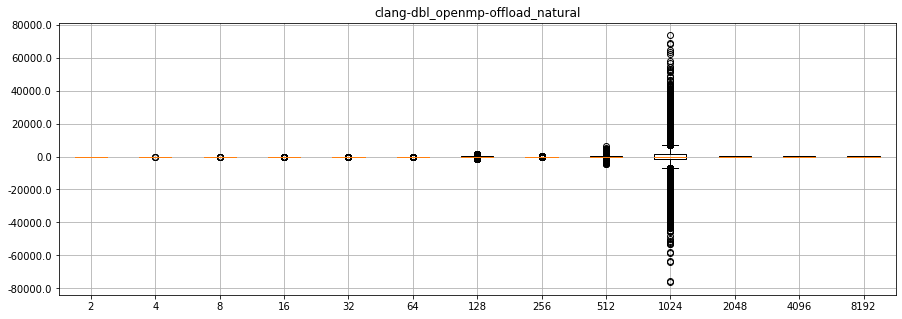

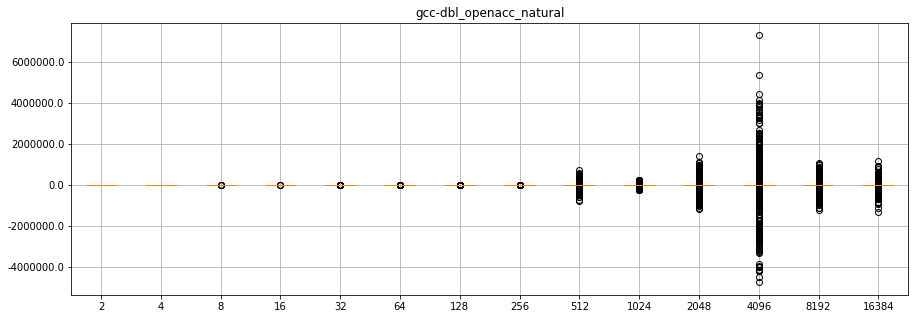

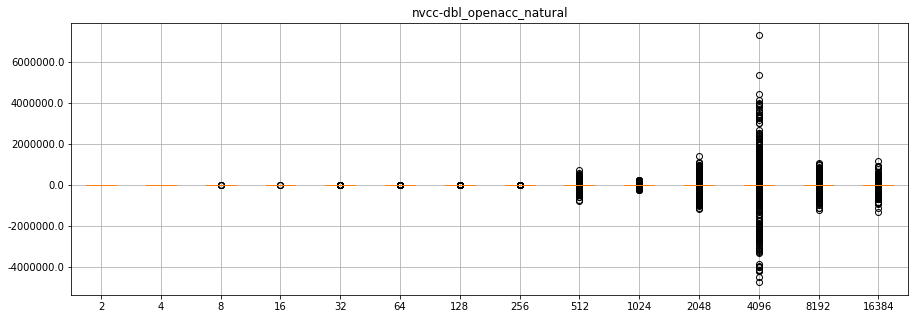

NaN or abrupts ending:  ../results/nvcc-offload-dbl_cuda_natural_4_double
NaN or abrupts ending:  ../results/nvcc-offload-dbl_cuda_natural_256_double
NaN or abrupts ending:  ../results/nvcc-offload-dbl_cuda_natural_512_double
NaN or abrupts ending:  ../results/nvcc-offload-dbl_cuda_natural_1024_double
0 7 
NaN or abrupts ending:  ../results/nvcc-offload-dbl_cuda_natural_2048_double
NaN or abrupts ending:  ../results/nvcc-offload-dbl_cuda_natural_4096_double
0 34 
NaN or abrupts ending:  ../results/nvcc-offload-dbl_cuda_natural_8192_double
0 395 
NaN or abrupts ending:  ../results/nvcc-offload-dbl_cuda_natural_16384_double


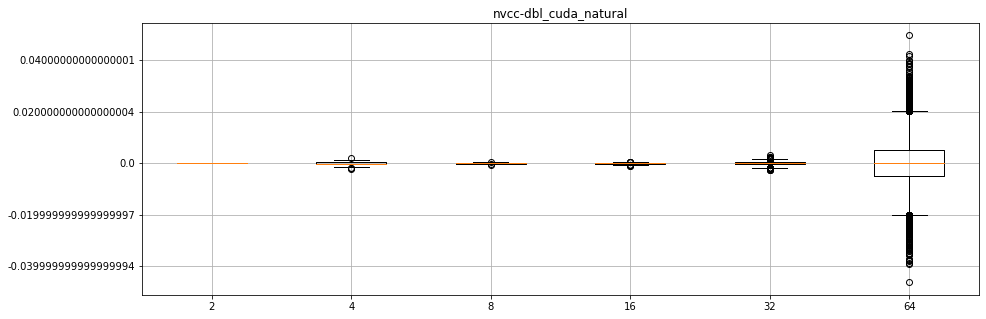

NaN or abrupts ending:  ../results/nvcc-offload-dbl_cublas_natural_256_double
file is empty:  ../results/nvcc-offload-dbl_cublas_natural_512_double
file is empty:  ../results/nvcc-offload-dbl_cublas_natural_1024_double
path does not exist:  ../results/nvcc-offload-dbl_cublas_natural_2048_double
path does not exist:  ../results/nvcc-offload-dbl_cublas_natural_4096_double
path does not exist:  ../results/nvcc-offload-dbl_cublas_natural_8192_double
path does not exist:  ../results/nvcc-offload-dbl_cublas_natural_16384_double


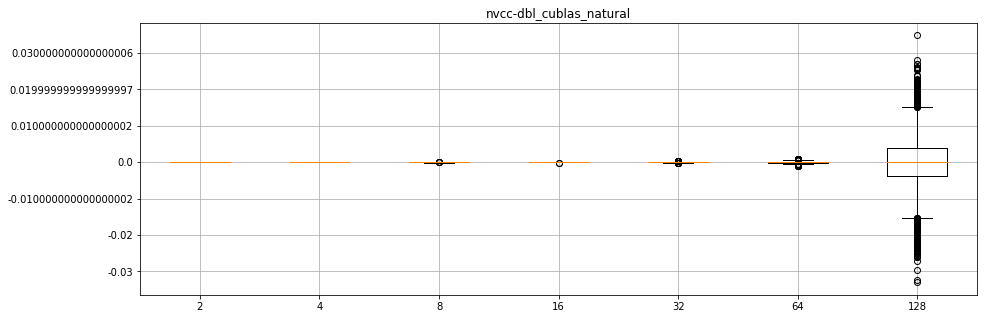

NaN or abrupts ending:  ../results/nvcc-offload-dbl_openmp-offload_natural_4_double
path does not exist:  ../results/nvcc-offload-dbl_openmp-offload_natural_2048_double
path does not exist:  ../results/nvcc-offload-dbl_openmp-offload_natural_4096_double
path does not exist:  ../results/nvcc-offload-dbl_openmp-offload_natural_8192_double
path does not exist:  ../results/nvcc-offload-dbl_openmp-offload_natural_16384_double


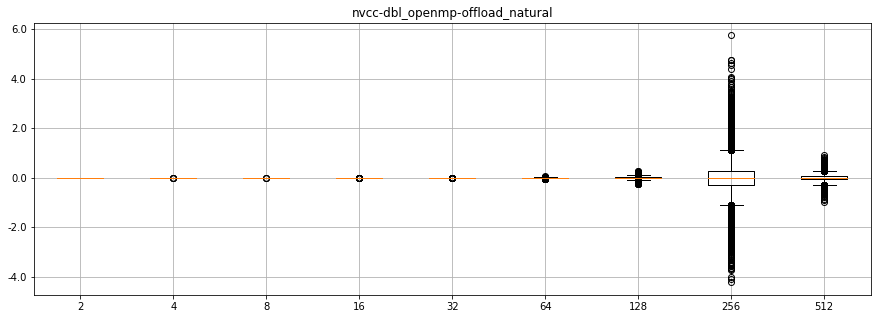

path does not exist:  ../results/gcc-offload-dbl_eigen_sparse_2048_double
path does not exist:  ../results/gcc-offload-dbl_eigen_sparse_4096_double
path does not exist:  ../results/gcc-offload-dbl_eigen_sparse_8192_double
path does not exist:  ../results/gcc-offload-dbl_eigen_sparse_16384_double


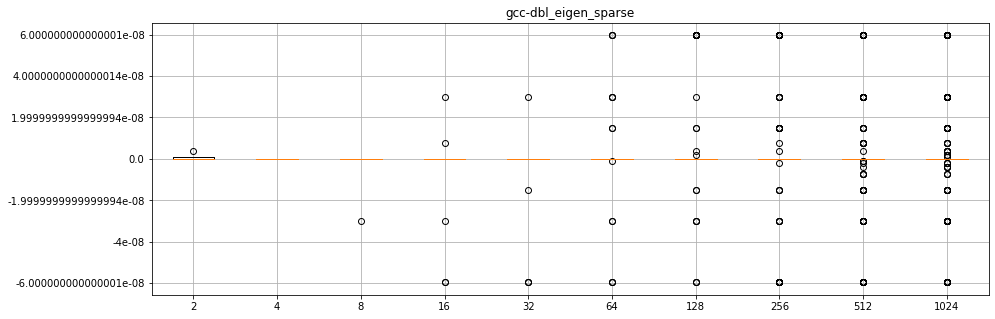

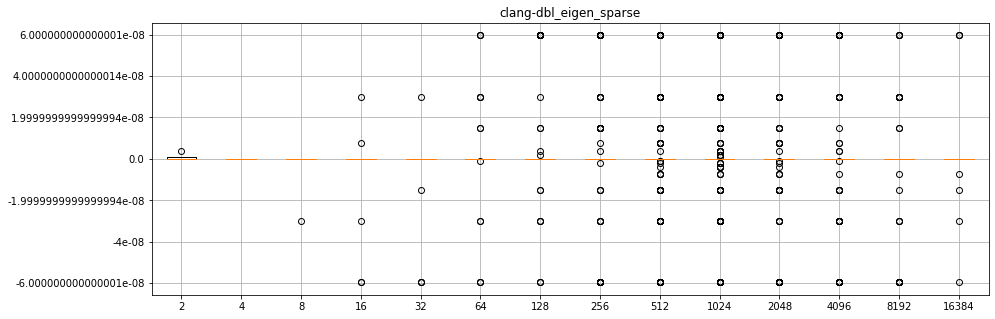

path does not exist:  ../results/gcc-offload-dbl_openmp-cpu_sparse_2048_double
path does not exist:  ../results/gcc-offload-dbl_openmp-cpu_sparse_4096_double
path does not exist:  ../results/gcc-offload-dbl_openmp-cpu_sparse_8192_double
path does not exist:  ../results/gcc-offload-dbl_openmp-cpu_sparse_16384_double


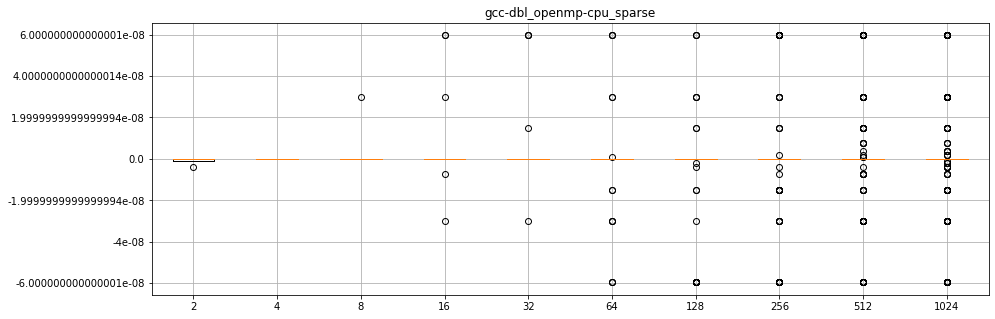

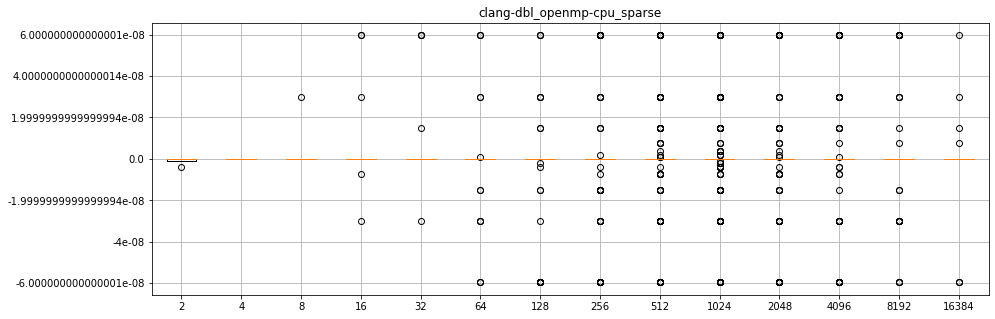

path does not exist:  ../results/gcc-offload-dbl_openmp-offload_sparse_2048_double
path does not exist:  ../results/gcc-offload-dbl_openmp-offload_sparse_4096_double
path does not exist:  ../results/gcc-offload-dbl_openmp-offload_sparse_8192_double
path does not exist:  ../results/gcc-offload-dbl_openmp-offload_sparse_16384_double


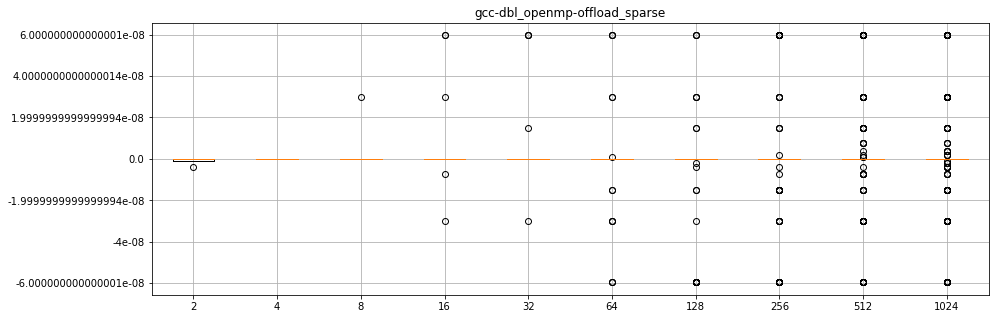

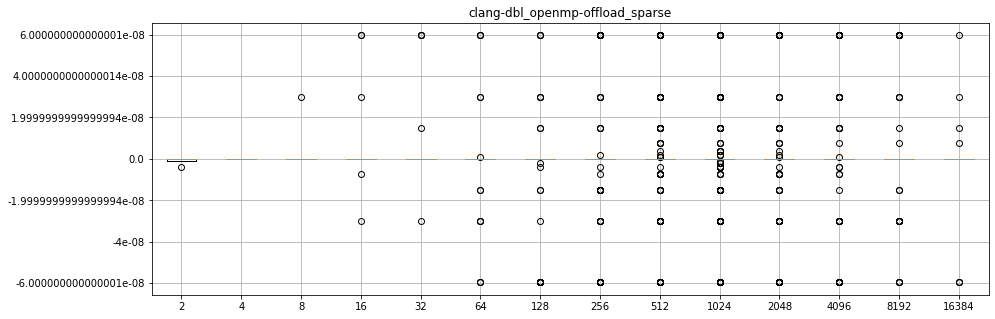

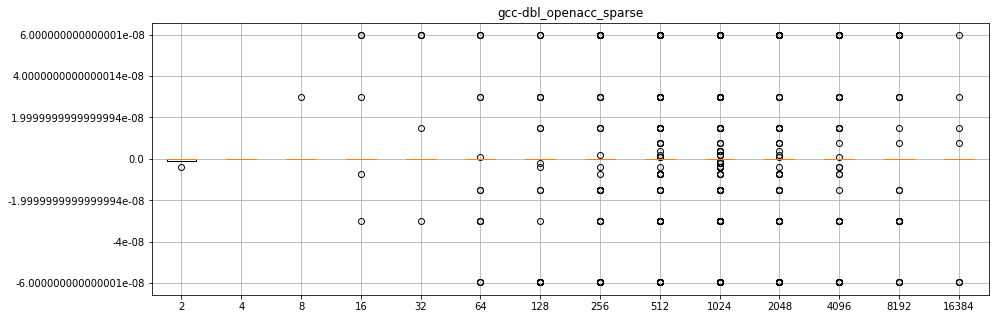

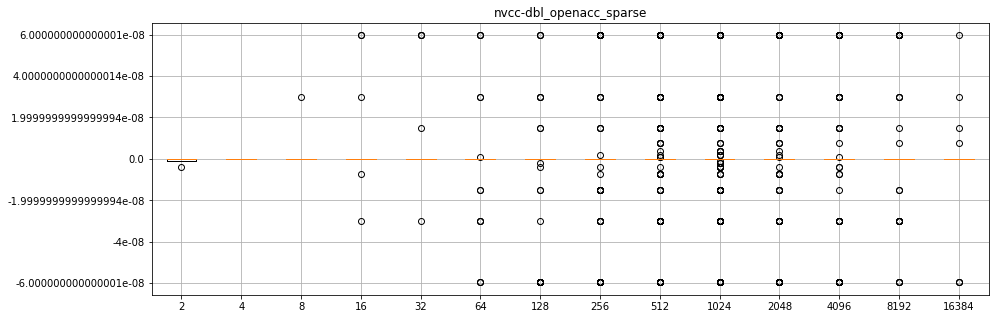

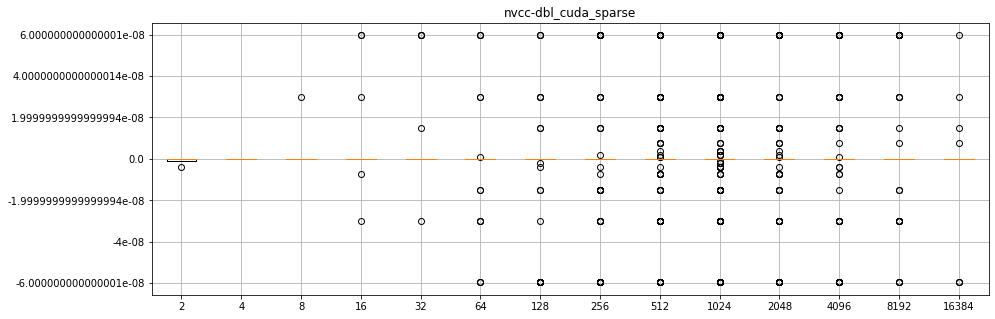

NaN or abrupts ending:  ../results/nvcc-offload-dbl_cublas_sparse_256_double
file is empty:  ../results/nvcc-offload-dbl_cublas_sparse_512_double
file is empty:  ../results/nvcc-offload-dbl_cublas_sparse_1024_double
path does not exist:  ../results/nvcc-offload-dbl_cublas_sparse_2048_double
path does not exist:  ../results/nvcc-offload-dbl_cublas_sparse_4096_double
path does not exist:  ../results/nvcc-offload-dbl_cublas_sparse_8192_double
path does not exist:  ../results/nvcc-offload-dbl_cublas_sparse_16384_double


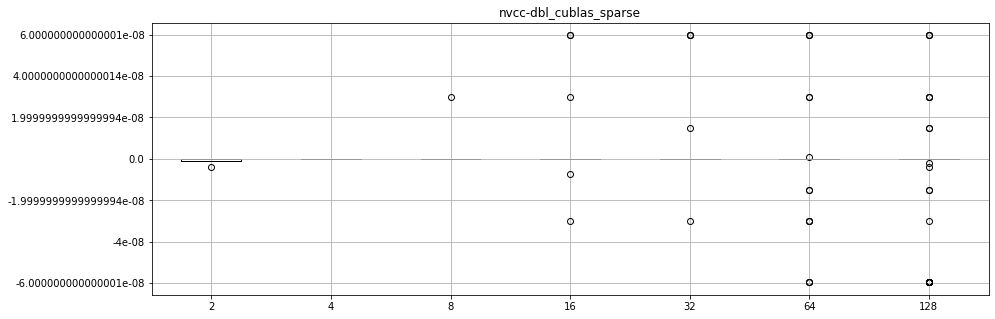

path does not exist:  ../results/nvcc-offload-dbl_openmp-offload_sparse_2048_double
path does not exist:  ../results/nvcc-offload-dbl_openmp-offload_sparse_4096_double
path does not exist:  ../results/nvcc-offload-dbl_openmp-offload_sparse_8192_double
path does not exist:  ../results/nvcc-offload-dbl_openmp-offload_sparse_16384_double


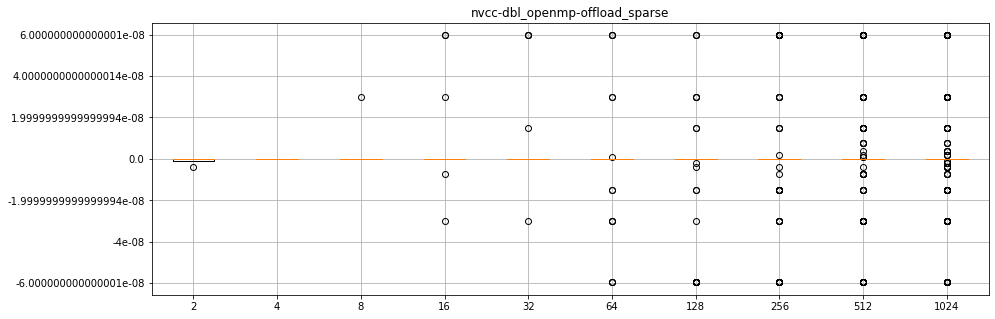

path does not exist:  ../results/gcc-offload-dbl_eigen_triangle_2048_double
path does not exist:  ../results/gcc-offload-dbl_eigen_triangle_4096_double
path does not exist:  ../results/gcc-offload-dbl_eigen_triangle_8192_double
path does not exist:  ../results/gcc-offload-dbl_eigen_triangle_16384_double


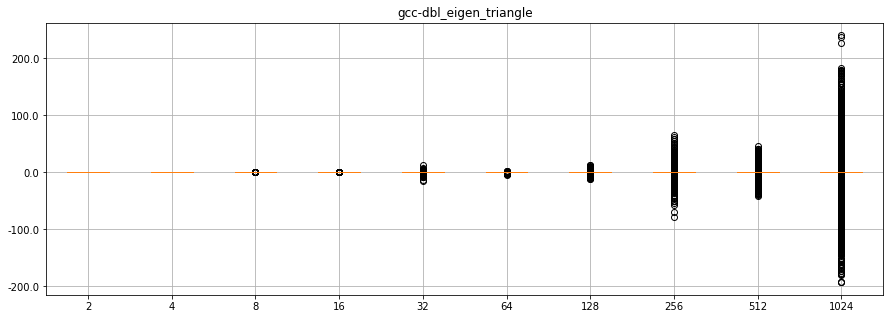

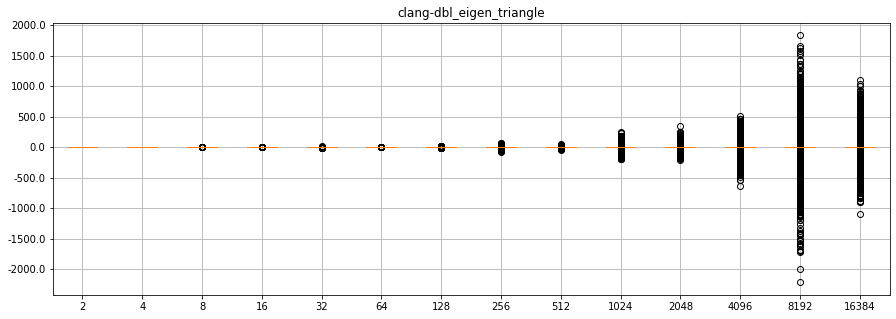

NaN or abrupts ending:  ../results/gcc-offload-dbl_openmp-cpu_triangle_256_double
NaN or abrupts ending:  ../results/gcc-offload-dbl_openmp-cpu_triangle_512_double
NaN or abrupts ending:  ../results/gcc-offload-dbl_openmp-cpu_triangle_1024_double
path does not exist:  ../results/gcc-offload-dbl_openmp-cpu_triangle_2048_double
path does not exist:  ../results/gcc-offload-dbl_openmp-cpu_triangle_4096_double
path does not exist:  ../results/gcc-offload-dbl_openmp-cpu_triangle_8192_double
path does not exist:  ../results/gcc-offload-dbl_openmp-cpu_triangle_16384_double


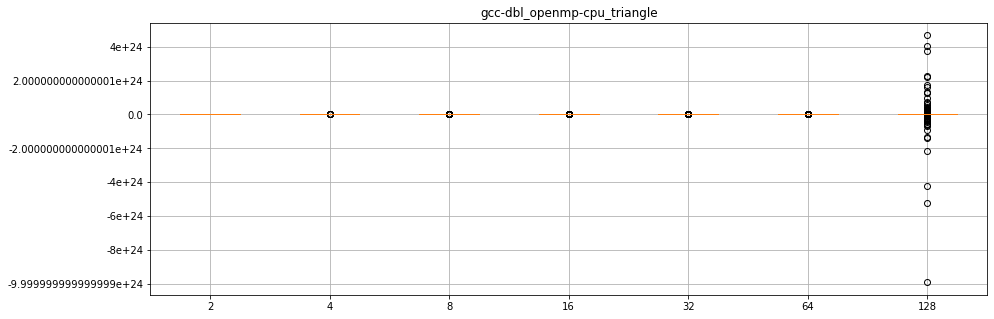

NaN or abrupts ending:  ../results/clang-offload-dbl_openmp-cpu_triangle_256_double
NaN or abrupts ending:  ../results/clang-offload-dbl_openmp-cpu_triangle_512_double
file is empty:  ../results/clang-offload-dbl_openmp-cpu_triangle_1024_double
file is empty:  ../results/clang-offload-dbl_openmp-cpu_triangle_2048_double
file is empty:  ../results/clang-offload-dbl_openmp-cpu_triangle_4096_double
file is empty:  ../results/clang-offload-dbl_openmp-cpu_triangle_8192_double
file is empty:  ../results/clang-offload-dbl_openmp-cpu_triangle_16384_double


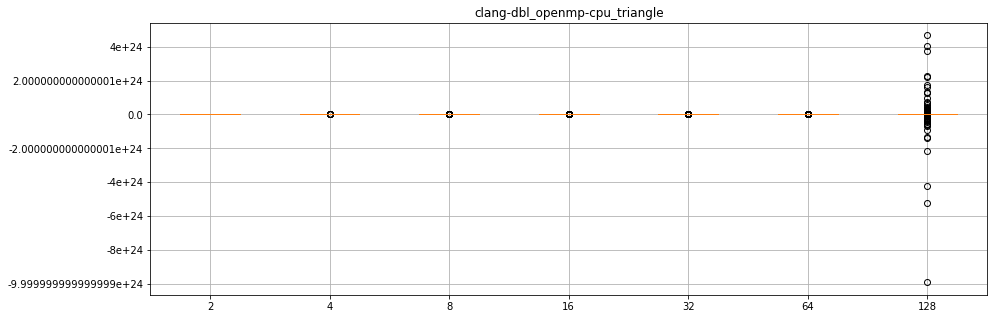

NaN or abrupts ending:  ../results/gcc-offload-dbl_openmp-offload_triangle_256_double
NaN or abrupts ending:  ../results/gcc-offload-dbl_openmp-offload_triangle_512_double
NaN or abrupts ending:  ../results/gcc-offload-dbl_openmp-offload_triangle_1024_double
path does not exist:  ../results/gcc-offload-dbl_openmp-offload_triangle_2048_double
path does not exist:  ../results/gcc-offload-dbl_openmp-offload_triangle_4096_double
path does not exist:  ../results/gcc-offload-dbl_openmp-offload_triangle_8192_double
path does not exist:  ../results/gcc-offload-dbl_openmp-offload_triangle_16384_double


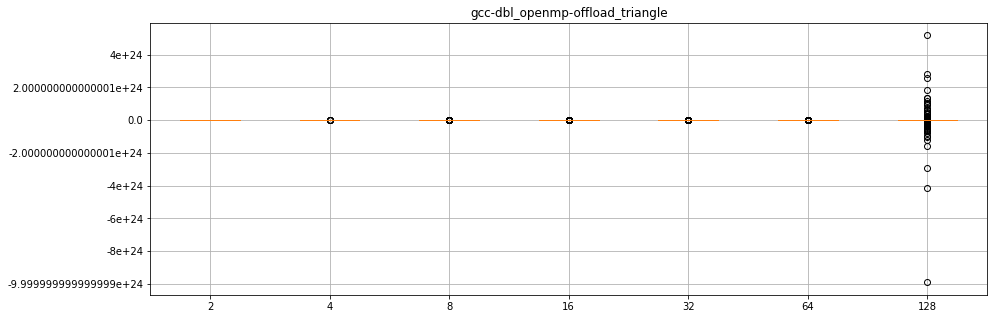

NaN or abrupts ending:  ../results/clang-offload-dbl_openmp-offload_triangle_256_double
NaN or abrupts ending:  ../results/clang-offload-dbl_openmp-offload_triangle_512_double
NaN or abrupts ending:  ../results/clang-offload-dbl_openmp-offload_triangle_1024_double
0 7 
NaN or abrupts ending:  ../results/clang-offload-dbl_openmp-offload_triangle_2048_double
NaN or abrupts ending:  ../results/clang-offload-dbl_openmp-offload_triangle_4096_double
0 34 
NaN or abrupts ending:  ../results/clang-offload-dbl_openmp-offload_triangle_8192_double
0 395 
NaN or abrupts ending:  ../results/clang-offload-dbl_openmp-offload_triangle_16384_double


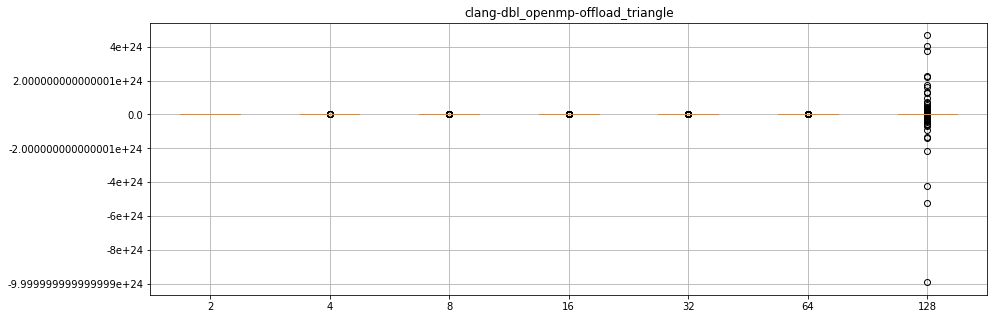

NaN or abrupts ending:  ../results/gcc-offload-acc-dbl_openacc_triangle_256_double
NaN or abrupts ending:  ../results/gcc-offload-acc-dbl_openacc_triangle_512_double
NaN or abrupts ending:  ../results/gcc-offload-acc-dbl_openacc_triangle_1024_double
0 7 
NaN or abrupts ending:  ../results/gcc-offload-acc-dbl_openacc_triangle_2048_double
NaN or abrupts ending:  ../results/gcc-offload-acc-dbl_openacc_triangle_4096_double
0 34 
NaN or abrupts ending:  ../results/gcc-offload-acc-dbl_openacc_triangle_8192_double
0 395 
NaN or abrupts ending:  ../results/gcc-offload-acc-dbl_openacc_triangle_16384_double


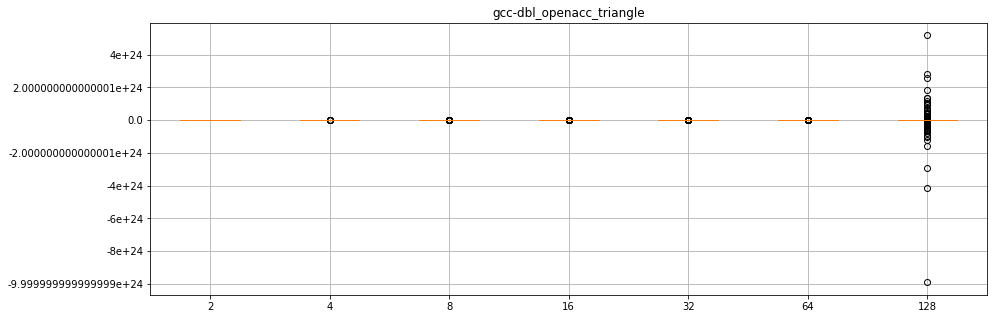

NaN or abrupts ending:  ../results/nvcc-offload-dbl_openacc_triangle_256_double
NaN or abrupts ending:  ../results/nvcc-offload-dbl_openacc_triangle_512_double
NaN or abrupts ending:  ../results/nvcc-offload-dbl_openacc_triangle_1024_double
0 7 
NaN or abrupts ending:  ../results/nvcc-offload-dbl_openacc_triangle_2048_double
NaN or abrupts ending:  ../results/nvcc-offload-dbl_openacc_triangle_4096_double
0 34 
NaN or abrupts ending:  ../results/nvcc-offload-dbl_openacc_triangle_8192_double
0 395 
NaN or abrupts ending:  ../results/nvcc-offload-dbl_openacc_triangle_16384_double


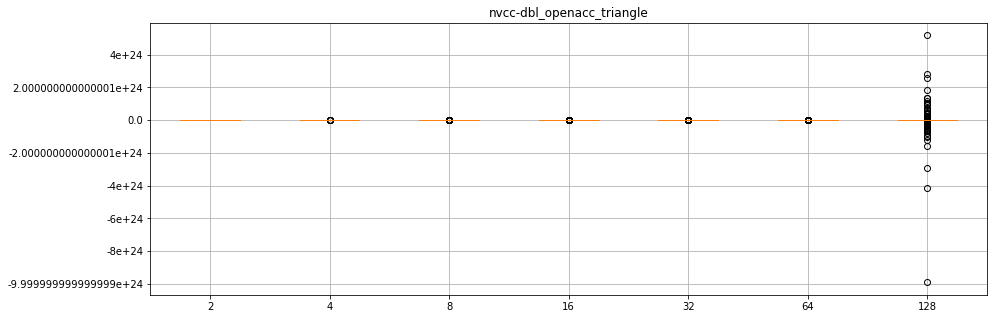

NaN or abrupts ending:  ../results/nvcc-offload-dbl_cuda_triangle_256_double
NaN or abrupts ending:  ../results/nvcc-offload-dbl_cuda_triangle_512_double
NaN or abrupts ending:  ../results/nvcc-offload-dbl_cuda_triangle_1024_double
0 7 
NaN or abrupts ending:  ../results/nvcc-offload-dbl_cuda_triangle_2048_double
NaN or abrupts ending:  ../results/nvcc-offload-dbl_cuda_triangle_4096_double
0 34 
NaN or abrupts ending:  ../results/nvcc-offload-dbl_cuda_triangle_8192_double
0 395 
NaN or abrupts ending:  ../results/nvcc-offload-dbl_cuda_triangle_16384_double


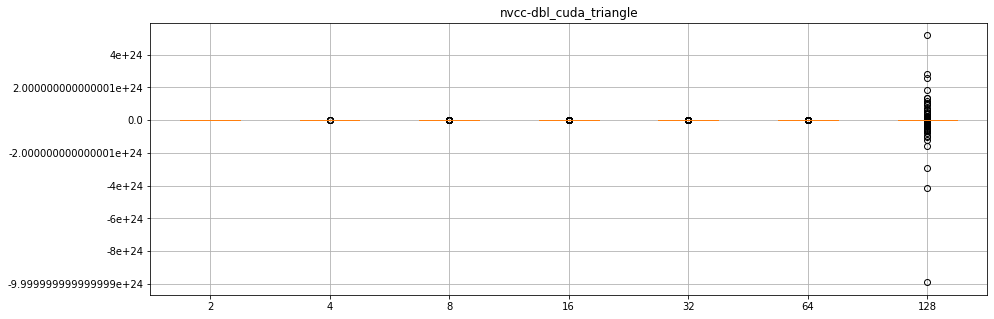

NaN or abrupts ending:  ../results/nvcc-offload-dbl_cublas_triangle_256_double
file is empty:  ../results/nvcc-offload-dbl_cublas_triangle_512_double
file is empty:  ../results/nvcc-offload-dbl_cublas_triangle_1024_double
path does not exist:  ../results/nvcc-offload-dbl_cublas_triangle_2048_double
path does not exist:  ../results/nvcc-offload-dbl_cublas_triangle_4096_double
path does not exist:  ../results/nvcc-offload-dbl_cublas_triangle_8192_double
path does not exist:  ../results/nvcc-offload-dbl_cublas_triangle_16384_double


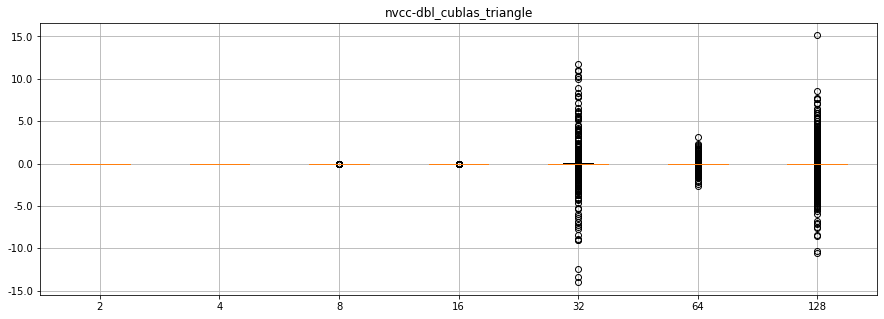

NaN or abrupts ending:  ../results/nvcc-offload-dbl_openmp-offload_triangle_256_double
NaN or abrupts ending:  ../results/nvcc-offload-dbl_openmp-offload_triangle_512_double
NaN or abrupts ending:  ../results/nvcc-offload-dbl_openmp-offload_triangle_1024_double
path does not exist:  ../results/nvcc-offload-dbl_openmp-offload_triangle_2048_double
path does not exist:  ../results/nvcc-offload-dbl_openmp-offload_triangle_4096_double
path does not exist:  ../results/nvcc-offload-dbl_openmp-offload_triangle_8192_double
path does not exist:  ../results/nvcc-offload-dbl_openmp-offload_triangle_16384_double


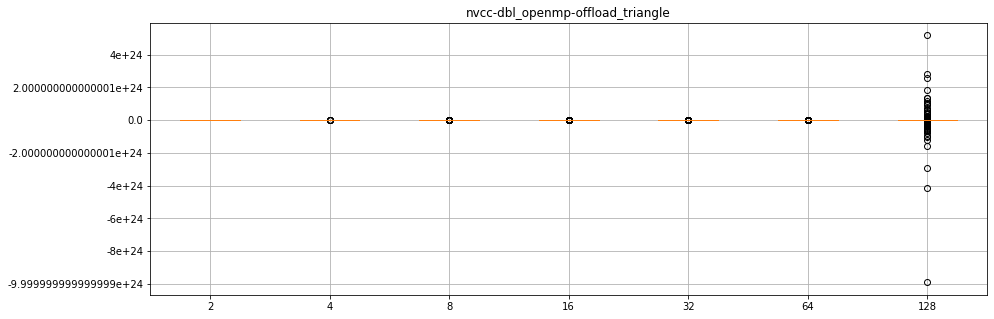

In [295]:
for dbl in [0, 1]:
    ext = "-dbl" if dbl else ""
    for typ in types:
        for alg in algorithms_gcc:
            plot_errors(process_errors("gcc-offload", alg, typ, dbl), "gcc" + ext + "_" + alg + "_" + typ)
            plot_errors(process_errors("clang-offload", alg, typ, dbl), "clang" + ext + "_" + alg + "_" + typ)
        plot_errors(process_errors("gcc-offload-acc", "openacc", typ, dbl), "gcc" + ext + "_openacc_" + typ)
        for alg in algorithms_nvcc:
            plot_errors(process_errors("nvcc-offload", alg, typ, dbl), "nvcc" + ext + "_" + alg + "_" + typ)

path does not exist:  ../results/gcc-offload_openmp-cpu_normal_2048
path does not exist:  ../results/gcc-offload_openmp-cpu_normal_4096
path does not exist:  ../results/gcc-offload_openmp-cpu_normal_8192
path does not exist:  ../results/gcc-offload_openmp-cpu_normal_16384
path does not exist:  ../results/gcc-offload_openmp-offload_normal_2048
path does not exist:  ../results/gcc-offload_openmp-offload_normal_4096
path does not exist:  ../results/gcc-offload_openmp-offload_normal_8192
path does not exist:  ../results/gcc-offload_openmp-offload_normal_16384
path does not exist:  ../results/gcc-offload-dbl_openmp-cpu_normal_2048_double
path does not exist:  ../results/gcc-offload-dbl_openmp-cpu_normal_4096_double
path does not exist:  ../results/gcc-offload-dbl_openmp-cpu_normal_8192_double
path does not exist:  ../results/gcc-offload-dbl_openmp-cpu_normal_16384_double
path does not exist:  ../results/gcc-offload-dbl_openmp-offload_normal_2048_double
path does not exist:  ../results/gcc-o

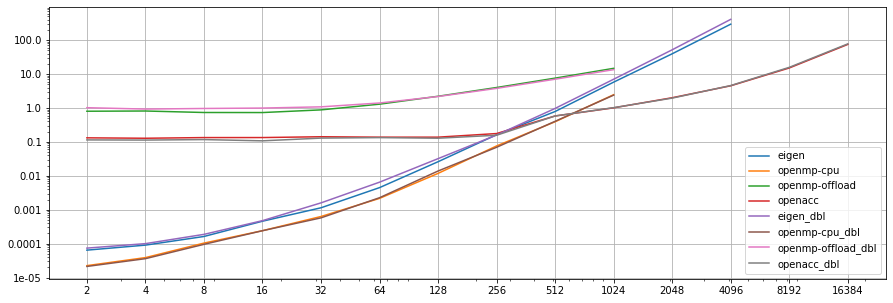

path does not exist:  ../results/nvcc-offload_openmp-offload_normal_2048
path does not exist:  ../results/nvcc-offload_openmp-offload_normal_4096
path does not exist:  ../results/nvcc-offload_openmp-offload_normal_8192
path does not exist:  ../results/nvcc-offload_openmp-offload_normal_16384
path does not exist:  ../results/nvcc-offload-dbl_cublas_normal_2048_double
path does not exist:  ../results/nvcc-offload-dbl_cublas_normal_4096_double
path does not exist:  ../results/nvcc-offload-dbl_cublas_normal_8192_double
path does not exist:  ../results/nvcc-offload-dbl_cublas_normal_16384_double
path does not exist:  ../results/nvcc-offload-dbl_openmp-offload_normal_2048_double
path does not exist:  ../results/nvcc-offload-dbl_openmp-offload_normal_4096_double
path does not exist:  ../results/nvcc-offload-dbl_openmp-offload_normal_8192_double
path does not exist:  ../results/nvcc-offload-dbl_openmp-offload_normal_16384_double


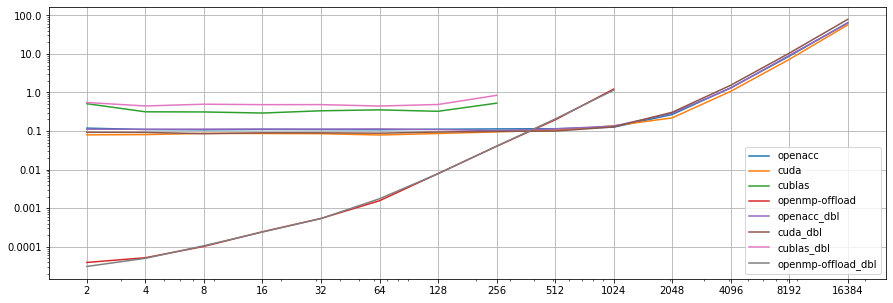

path does not exist:  ../results/clang-offload_openmp-offload_normal_2048
path does not exist:  ../results/clang-offload_openmp-offload_normal_4096
path does not exist:  ../results/clang-offload_openmp-offload_normal_8192
path does not exist:  ../results/clang-offload_openmp-offload_normal_16384


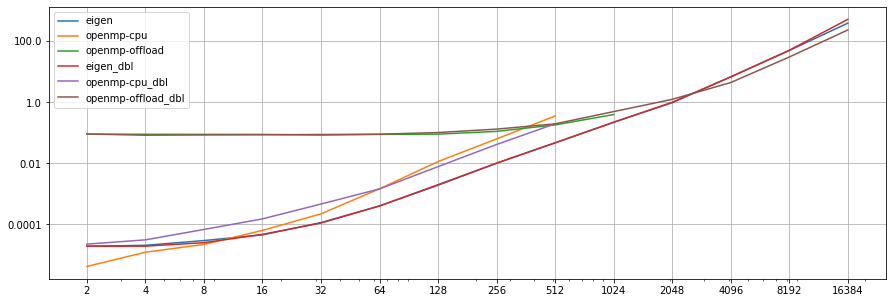

In [19]:
for typ in ["normal"]:
    data = []
    
    ext = "-dbl" if dbl else ""
    for dbl in [0, 1]:
        for alg in algorithms_gcc:
            data.append([process_timings("gcc-offload", alg, typ, dbl), alg, dbl])
        data.append([process_timings("gcc-offload-acc", "openacc", typ, dbl), "openacc", dbl])
    plot_timings(data, "gcc" + ext + "_" + typ)
    data = []
    for dbl in [0, 1]:
        for alg in algorithms_nvcc:
            data.append([process_timings("nvcc-offload", alg, typ, dbl), alg, dbl])
    plot_timings(data, "nvcc" + ext + "_" + typ)
    
    data = []
    for dbl in [0, 1]:
        for alg in algorithms_gcc:
            data.append([process_timings("clang-offload", alg, typ, dbl), alg, dbl])
    plot_timings(data, "clang" + ext + "_" + typ)

path does not exist:  ../results/gcc-offload_openmp-cpu_normal_2048
path does not exist:  ../results/gcc-offload_openmp-cpu_normal_4096
path does not exist:  ../results/gcc-offload_openmp-cpu_normal_8192
path does not exist:  ../results/gcc-offload_openmp-cpu_normal_16384
path does not exist:  ../results/gcc-offload_openmp-offload_normal_2048
path does not exist:  ../results/gcc-offload_openmp-offload_normal_4096
path does not exist:  ../results/gcc-offload_openmp-offload_normal_8192
path does not exist:  ../results/gcc-offload_openmp-offload_normal_16384
path does not exist:  ../results/clang-offload_openmp-offload_normal_2048
path does not exist:  ../results/clang-offload_openmp-offload_normal_4096
path does not exist:  ../results/clang-offload_openmp-offload_normal_8192
path does not exist:  ../results/clang-offload_openmp-offload_normal_16384


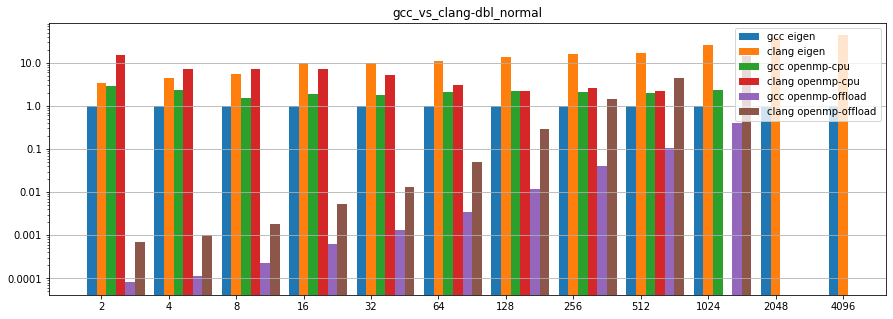

path does not exist:  ../results/nvcc-offload_openmp-offload_normal_2048
path does not exist:  ../results/nvcc-offload_openmp-offload_normal_4096
path does not exist:  ../results/nvcc-offload_openmp-offload_normal_8192
path does not exist:  ../results/nvcc-offload_openmp-offload_normal_16384
path does not exist:  ../results/gcc-offload_openmp-offload_normal_2048
path does not exist:  ../results/gcc-offload_openmp-offload_normal_4096
path does not exist:  ../results/gcc-offload_openmp-offload_normal_8192
path does not exist:  ../results/gcc-offload_openmp-offload_normal_16384


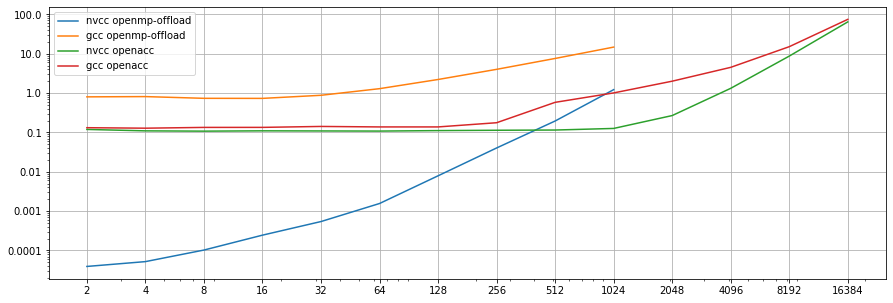

In [33]:
typ = "normal"
dbl = False

data = []
for alg in algorithms_gcc:
    data.append([process_timings("gcc-offload", alg, typ, dbl), "gcc " + alg])
    data.append([process_timings("clang-offload", alg, typ, dbl), "clang " + alg])
base = data.pop(0)
plot_speedup(base, data, "gcc_vs_clang" + ext + "_" + typ)

data = []
alg = "openmp-offload"
data.append([process_timings("nvcc-offload", alg, typ, dbl), "nvcc " + alg])
data.append([process_timings("gcc-offload", alg, typ, dbl), "gcc " + alg])
alg = "openacc"
data.append([process_timings("nvcc-offload", alg, typ, dbl), "nvcc " + alg])
data.append([process_timings("gcc-offload-acc", alg, typ, dbl), "gcc " + alg])
plot_timings(data, "nvcc" + ext + "_" + typ)
